# Latent Dirichlet Allocation

 A common method to quickly understand trends in topics being discussed in a corpus of text is Latent Dirichlet Allocation (LDA).<br><br>

LDA assumes each document consists of a combination of topics, and each topic consists of a combination of words. It then approximates probability distributions of topics in a given document and of words in a given topic. The algorithm uses collapsed Gibbs Sampling:
   1. Given a set of documents, go through each document, and randomly assign each word in the document to one of the K topics
       - This gives random assignment of topic representations of all the documents and word distributions of all the topics
       - Because this is random, it will not be good
   2. To improve, for each document D, go through each word in D:
       - For each topic t, compute:
           - $ p(topic_t | document_d)$ = proportion of words in document d that are assigned to topic t
           - $ p(word_w | topic_t)$ = proportion of assignments to topic t over all documents that come from word w (how many w in all documents' words are assigned to t)
           - Reassign with a new topic, where we choose topic t with probability $p(topic_t|document_d)*p(word_w|topic_t)$, which is essentially the probability that topic t generated word w
       - Update assignment of current word in the loop assuming topic assignment distributions for the rest of the corpus are correct
   3. Keep iterating until assignments reach a steady state
       - Use these assignments to estimate topic mixtures of each document (\% words assigned to each topic within that document) and word associated to each topic (\% of words assigned to each topic overall)


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from google.colab import files, drive

# mount your google drive 
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import spacy
import nltk
import re
import string
import pandas as pd
import numpy as np
import datetime
import time
import pickle
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
!pip install q pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# NLTK Stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Plotting
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa
/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing th

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Pre-processing

In [ ]:
nlp = spacy.load('en')
STOPWORDS_DICT = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}

def clean_all(df, col_name):
    """
    Combines all functions used to clean and lemmatize the comments.
    :param df: data frame with comments
    :param col_name: column name in data frame containing comments
    :return: data frame with comments column lemmatized
    """

    # encode for only ascii characters
    df[col_name] = df[col_name].map(ascii_rm)
    
    # lowercase texts
    df[col_name] = df[col_name].map(lambda x: x.lower())


    # lemmatize words
    df[col_name] = df[col_name].astype(str).map(lemma)

    # remove punctuation
    df[col_name] = df[col_name].map(punc_n)


    # filter only english comments/non blank comments
    df['language'] = df[col_name].map(get_language)
    df = df.loc[df['language'] == 'english']
    df = df.drop('language', axis=1)
    df = df[df[col_name] != ""]
    
    return df


def ascii_rm(comment):
    """
    Parses comments and keep only ascii characters
    :param comment: a comment
    :return: comment with only ascii characters
    """
    comment = comment.encode('ascii', errors = 'ignore')
    return comment

def get_language(text):
    """
    Determines what language the comment is written in and filters only English comments.
    :param text: comment
    :return: language of comment
    """
    words = set(nltk.wordpunct_tokenize(text.lower()))
    return max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key = lambda x: x[1])[0]


def punc_n(comment):
    """
    Removes punctuations from comments.
    :param comment: a comment
    :return: comment without punctuations
    """
    regex = re.compile('[' + re.escape('!"#%&\'()*+,-./:;<=>?@[\\]^_`{|}~')+'0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", comment)
    nopunct_words = nopunct.split(' ')
    filter_words = [word.strip() for word in nopunct_words if word != '']
    words = ' '.join(filter_words)
    return words



def lemma(comment):
    """
    Lemmatize comments using spacy lemmatizer.
    :param comment: a comment
    :return: lemmatized comment
    """
    lemmatized = nlp(comment)
    lemmatized_final = ' '.join([word.lemma_ for word in lemmatized if word.lemma_ != '\'s'])
    return lemmatized_final

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


## Load and Clean Text

In [ ]:
# Import sentiment scores and filtered data
base_directory = '/gdrive/My Drive/SY2020-2021/SARC 5400/2016_election_speeches.csv'

keywords_df = pd.read_csv(base_directory)
keywords_df.head(3)

,id,speaker,date,title,transcript_type,speech
0,oWlLZZ8pcp8,trump,2019-04-28T02:07:41Z,Watch Live: President Trump's MAGA Rally in Gr...,speech,[Music] [Music] [Music] [Music] [Music] [Appla...
1,Z6N1WdJgnLo,biden,2019-04-29T21:04:46Z,Joe Biden holds first 2020 campaign rally,speech,[Applause] [Music] my name [Applause] thank yo...
2,WIwGrZKdsY0,trump,2019-05-09T03:55:17Z,FULL RALLY: President Trump in Panama City Bea...,speech,[Music] from the leaves of Minnesota [Music] a...


In [ ]:
keywords_df.speaker.value_counts()

trump     81
biden     49
pence     28
harris    14
Name: speaker, dtype: int64

In [ ]:
biden = keywords_df[keywords_df["speaker"] == "biden"]
trump = keywords_df[keywords_df["speaker"] == "trump"]
pence = keywords_df[keywords_df["speaker"] == "pence"]
harris = keywords_df[keywords_df["speaker"] == "harris"]

In [ ]:
df = harris
df["reviewText"] = df["speech"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df.head()

,id,speaker,date,title,transcript_type,speech,reviewText
5,S7j1hYXD0uk,harris,2019-06-10T03:00:01Z,Full speech: Kamala Harris | Iowa Democrats’ H...,speech,it's good to be back with you it is great to b...,it's good to be back with you it is great to b...
65,hHYIWW5n5Rg,harris,2020-08-12T22:17:49Z,Democratic VP candidate Kamala Harris speaks a...,speech,thank you joe thank you thank you joe as i sai...,thank you joe thank you thank you joe as i sai...
70,JijFLcbIqMs,harris,2020-08-20T03:41:13Z,WATCH: Kamala Harris’ full speech at the 2020 ...,speech,Greetings America. It is truly an honor to be ...,Greetings America. It is truly an honor to be ...
73,Og8PLfNwNOw,harris,2020-08-27T19:30:31Z,Kamala Harris to discuss Trump's response to c...,speech,D AFTERNOON. ON THE EVE OF THE FIFTY SEVENTH M...,D AFTERNOON. ON THE EVE OF THE FIFTY SEVENTH M...
106,YuNJUS7pbSM,harris,2020-09-28T19:09:58Z,Kamala Harris Responds LIVE to Trump’s Supreme...,speech,>>Please welcome Senator Kamala Harris. KAMALA...,>>Please welcome Senator Kamala Harris. KAMALA...


In [ ]:
clean_reviews = clean_all(df, 'reviewText')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [ ]:
clean_reviews

,id,speaker,date,title,transcript_type,speech,reviewText
5,S7j1hYXD0uk,harris,2019-06-10T03:00:01Z,Full speech: Kamala Harris | Iowa Democrats’ H...,speech,it's good to be back with you it is great to b...,b it good to be back with PRON PRON be great t...
65,hHYIWW5n5Rg,harris,2020-08-12T22:17:49Z,Democratic VP candidate Kamala Harris speaks a...,speech,thank you joe thank you thank you joe as i sai...,b thank PRON joe thank PRON thank PRON joe as ...
70,JijFLcbIqMs,harris,2020-08-20T03:41:13Z,WATCH: Kamala Harris’ full speech at the 2020 ...,speech,Greetings America. It is truly an honor to be ...,b greetings america PRON be truly an honor to ...
73,Og8PLfNwNOw,harris,2020-08-27T19:30:31Z,Kamala Harris to discuss Trump's response to c...,speech,D AFTERNOON. ON THE EVE OF THE FIFTY SEVENTH M...,b d afternoon on the eve of the fifty seventh ...
106,YuNJUS7pbSM,harris,2020-09-28T19:09:58Z,Kamala Harris Responds LIVE to Trump’s Supreme...,speech,>>Please welcome Senator Kamala Harris. KAMALA...,b please welcome senator kamala harris kamala ...
117,t_G0ia3JOVs,harris,2020-10-07T00:00:00Z,VP Debate (Harris),speech,"Thank you, Susan. Well, the American people ha...",b thank PRON susan well the american people ha...
139,ZCTtBFeuZPc,harris,2020-10-19T16:42:22Z,Kamala Harris Early Vote Mobilization Event in...,speech,(MUSIC) >>> PLEASE WELCOME CONGRESSWOMAN VAL...,b music please welcome congresswoman val demin...
141,bxuykoOlwjA,harris,2020-10-20T01:00:12Z,"Trump blasts Joe Biden, mocks Kamala Harris at...",speech,oh thank you thank you what a crowd wow wow th...,b oh thank PRON thank PRON what a crowd wow wo...
143,tes38JVOLM0,harris,2020-10-21T01:47:37Z,"Kamala Harris gets REAL with CJ McCollum, Dono...",speech,ladies and gentlemen good afternoon from the f...,b ladie and gentleman good afternoon from the ...
150,eGhM2w3Wt_M,harris,2020-10-23T22:08:00Z,"Kamala Harris Democratic, vice presidential no...",speech,future all right good evening can you hear me ...,b future all right good evening can PRON hear ...


In [ ]:
clean_reviews.to_csv('harris.csv')
files.download('harris.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Form Bigrams & Trigrams

We want to identify bigrams and trigrams so we can concatenate them and consider them as one word. Bigrams are phrases containing 2 words e.g. ‘social media’, where ‘social’ and ‘media’ are more likely to co-occur rather than appear separately. Likewise, trigrams are phrases containing 3 words that more likely co-occur e.g. ‘Proctor and Gamble’. We use Pointwise Mutual Information score to identify significant bigrams and trigrams to concatenate. We also filter bigrams or trigrams with the filter (noun/adj, noun), (noun/adj,all types,noun/adj) because these are common structures pointing out noun-type n-grams. This helps the LDA model better cluster topics.

In [ ]:
# Import sentiment scores and filtered data
base_directory = '/gdrive/My Drive/SY2020-2021/SARC 5400/'
clean_reviews = pd.read_csv(base_directory+"biden.csv")

In [ ]:
stop_word_list = ["issue","problem","level", "face","unsweetened", "almond", "milk","belly", "button", "fnut", "j", "c","peanut", "butter", "nlm","gt", "utm","r", "comment","src", "hashtag", "click", "q","k","ds", "dna", "survey","rand","pjpg", "format","redd","snrnp", "pac", "z","jpg", "width", "gi", "x", "www","aggragate", "xftmya", "ybso", "url", "sitebuttons", "unc", "chapel","tsp", "kratom", "szhfjzs", "cy","meq", "szhfjzs", "loledit", "chickene", "b","uclah", "sv", "vpvlqaqyi", "tmg","iwar", "fbclid", "npw","lead","maybe","enb", "mean","fyhtykwamn", "wvxkt", "blood","right", "leave", "company","create", "low", "lol", "wear","new","lunatic","normal", "active","follow","opinion","figure,""limit", "make","weeks", "construction","see","woman","multiple","cinema","lavend","field","dark","loved","fondly","cope","exercise","catch","bit","specifically","look","date","system","share","matter","regularly",
                   "throw","s","ski","ahead","fully","affect","addition","result","tolerance", "whenever","favorite","acronym","water","reasonable","atm", "grow", "breathe", "focus", "study", "produce", "reminder","diarrhea", "leg", "end","super","loss","appear", "improve", "spoken", "tier", "worth", "mind", "opportunity", "adhd", "physically", "ensure", "article", "link", "course", "reach", "wrong", "joint", "write", "expect", "consider", "ever", "easy","similar",
                   "email","nee","cool","buy","receive","small","build","manage","damage","bio","many","doc","seriously","omg","ft","rn","head","sit","helpful","reduce","come","person","show","luck","video","collect","common","team","point_also","will","med","back","learn","add","hour", "usually", "keep","also","serious", "ask", "isssue","rule", "stop","manually","set", "factor","approach","oppose", "attempt", "curious", "reality", "noise", "due", "often",
                   "arm","ucrh_mal","rn","stick","let","barely","impossible","act","kind","surround","fighter","usual", "understandably", "shortly", "prior", "immediate", "order", "side", "redcap", "period","days","total","able", "understanding", "understand", "paper", "crohn","wreaks", "sound", "misread", "visit", "strongly", "seek", "attach", "await", "change", "living", "crap", "area", "weekly","late","top","respect","effect","nice","hot","have", "belief", 
                   "rub", "hence", "frequently","forget", "free", "mmr", "map", "hand", "screw", "never", "https", "constantly","aspect","really","may","lot","full","enough","hard","project","other","otherwise","distract","enjoy","poope","interested","function","mess","get","son","however","first","anyway","recommend","functional","sweet","way","go","rectal","offer","incorporate","speak","self","even","type","mile","forward","strong","perceive","broad",
                   "whole","early","cam","much","large","else","finally","last","appreciate","read","day", "mydn","roll","part", "check", "meal","do","real","discuss","absence","list","yesterday", "room","later","none","begin","describe","slight","break","week", "up","move","lupus","chrohn","ure","already","term","twvwipavjd","practice","hear","hearing","treat","rather","perspective","feel", "hold", "fellow", "current", "thought","well","think", "care", "high", "little", "know", 
                   "time", "start", "month", "wonder", "shit", "tell", "need", "long", "things", "thing", "hours", "try", "thank", "obviously", "year", "talk", "anti", "daily", "allow", "want", "tomorrow", "months", "july", "recently", "far","co","devin_currently", "april", "summer", "put",  "march", "associate", "sure", "haven", "friday", "great", "dont", "post", "easier", "pretty", "higher", "good", "years", "currently", "precision","eat","tmrw", 
                   "stephani", "happen", "second", "yawn" "fully", "soon", "sorry", "tuesday", "till", "smallest", "shouldn", "gatorade", "name", "completely", "today", "couldn","wasn", "lose", "longer","picture", "explain","twice", "yet","seem","seem","one","highly", "promise","annoy", "wing","advance","personally","tear","turn","potential","note","regard","pass","send", "possible","definitely","anymore","reason","guy","guess", "sort","reply","next", "actually", 
                   "suppose", "require","absolutely", "still","topic","highlight","probably","january","beautiful","book","bring", "life","several", "better","decade","michigan", "pred", "deal", "best", "say","could","aim","fill","stretch","tia","hip","form","instead","especially","would","include","old","likely","situation","use","work","find","positive", "butterfly", "specific", "love","huge", "adult","com","accept","skill","cause","https_www","live","taper",
                   "fail","counter","post_new","sign", "figure", "wife","double", "june", "people", "place", "drink", "food", "afternoon", "plan", "stuff", "recall", "past", "maintain", "cover", "page", "dairy", "status", "hair", "point", "fine", "sport", "experience", "watch", "wait", "weird", "fall", "plus", "night", "basically", "meat", "spot", "different", "walk", "away", "like", "tolerate", "itchy", "fuck", "half", "random", "nearly", "everyday", "play", "salt", "prep",
                   "generally", "yellow", "green", "board", "hop", "couple", "morning", "line", "upper", "yawn","warm", "chat", "felt", "accompany", "thoughts", "february", "monday", "extremely", "wake", "somewhat", "aren", "chicken", "sunday", "lower", "game", "incredibly", "temporarily", "notice", "lay", "finger", "sell", "tract", "minutes", "literally", "print", "shut", "cross", "feet"] + ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'computer', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'did', 'didn', 'do', 'does', 'doesn', 'doing', 'don', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fify', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 'full', 'further', 'get', 'give', 'go', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'hundred', 'i', 'ie', 'if', 'in', 'inc', 'indeed', 'interest', 'into', 'is', 'it', 'its', 'itself', 'just', 'keep', 'kg', 'km', 'last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made', 'make', 'many', 'may', 'me', 'meanwhile', 'might', 'mill', 'mine', 'more', 'moreover', 'most', 'mostly', 'move', 'much', 'must', 'my', 'myself', 'name', 'namely', 'neither', 'never', 'nevertheless', 'next', 'nine', 'no', 'nobody', 'none', 'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'once', 'one', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'part', 'per', 'perhaps', 'please', 'put', 'quite', 'rather', 'rather', 're', 'really', 'regarding', 'same', 'say', 'see', 'seem', 'seemed', 'seeming', 'seems', 'serious', 'several', 'she', 'should', 'show', 'side', 'since', 'sincere', 'six', 'sixty', 'so', 'some', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhere', 'still', 'such', 'system', 'take', 'ten', 'than', 'that', 'the', 'their', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'thereupon', 'these', 'they', 'thick', 'thin', 'third', 'this', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 'too', 'top', 'toward', 'towards', 'twelve', 'twenty', 'two', 'un', 'under', 'unless', 'until', 'up', 'upon', 'us', 'used', 'using', 'various', 'very', 'very', 'via', 'was', 'we', 'well', 'were', 'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with', 'within', 'without', 'would', 'yet', 'you', 'your', 'yours', 'yourself', 'yourselves']
english_names = ['aaren', 'aarika', 'abagael', 'abagail', 'abbe', 'abbey', 'abbi', 'abbie', 'abby', 'abbye', 'abigael', 'abigail', 'abigale', 'abra', 'ada', 'adah', 'adaline', 'adan', 'adara', 'adda', 'addi', 'addia', 'addie', 'addy', 'adel', 'adela', 'adelaida', 'adelaide', 'adele', 'adelheid', 'adelice', 'adelina', 'adelind', 'adeline', 'adella', 'adelle', 'adena', 'adey', 'adi', 'adiana', 'adina', 'adora', 'adore', 'adoree', 'adorne', 'adrea', 'adria', 'adriaens', 'adrian', 'adriana', 'adriane', 'adrianna', 'adrianne', 'adriena', 'adrienne', 'aeriel', 'aeriela', 'aeriell', 'afton', 'ag', 'agace', 'agata', 'agatha', 'agathe', 'aggi', 'aggie', 'aggy', 'agna', 'agnella', 'agnes', 'agnese', 'agnesse', 'agneta', 'agnola', 'agretha', 'aida', 'aidan', 'aigneis', 'aila', 'aile', 'ailee', 'aileen', 'ailene', 'ailey', 'aili', 'ailina', 'ailis', 'ailsun', 'ailyn', 'aime', 'aimee', 'aimil', 'aindrea', 'ainslee', 'ainsley', 'ainslie', 'ajay', 'alaine', 'alameda', 'alana', 'alanah', 'alane', 'alanna', 'alayne', 'alberta', 'albertina', 'albertine', 'albina', 'alecia', 'aleda', 'aleece', 'aleen', 'alejandra', 'alejandrina', 'alena', 'alene', 'alessandra', 'aleta', 'alethea', 'alex', 'alexa', 'alexandra', 'alexandrina', 'alexi', 'alexia', 'alexina', 'alexine', 'alexis', 'alfi', 'alfie', 'alfreda', 'alfy', 'ali', 'alia', 'alica', 'alice', 'alicea', 'alicia', 'alida', 'alidia', 'alie', 'alika', 'alikee', 'alina', 'aline', 'alis', 'alisa', 'alisha', 'alison', 'alissa', 'alisun', 'alix', 'aliza', 'alla', 'alleen', 'allegra', 'allene', 'alli', 'allianora', 'allie', 'allina', 'allis', 'allison', 'allissa', 'allix', 'allsun', 'allx', 'ally', 'allyce', 'allyn', 'allys', 'allyson', 'alma', 'almeda', 'almeria', 'almeta', 'almira', 'almire', 'aloise', 'aloisia', 'aloysia', 'alta', 'althea', 'alvera', 'alverta', 'alvina', 'alvinia', 'alvira', 'alyce', 'alyda', 'alys', 'alysa', 'alyse', 'alysia', 'alyson', 'alyss', 'alyssa', 'amabel', 'amabelle', 'amalea', 'amalee', 'amaleta', 'amalia', 'amalie', 'amalita', 'amalle', 'amanda', 'amandi', 'amandie', 'amandy', 'amara', 'amargo', 'amata', 'amber', 'amberly', 'ambur', 'ame', 'amelia', 'amelie', 'amelina', 'ameline', 'amelita', 'ami', 'amie', 'amii', 'amil', 'amitie', 'amity', 'ammamaria', 'amy', 'amye', 'ana', 'anabal', 'anabel', 'anabella', 'anabelle', 'analiese', 'analise', 'anallese', 'anallise', 'anastasia', 'anastasie', 'anastassia', 'anatola', 'andee', 'andeee', 'anderea', 'andi', 'andie', 'andra', 'andrea', 'andreana', 'andree', 'andrei', 'andria', 'andriana', 'andriette', 'andromache', 'andy', 'anestassia', 'anet', 'anett', 'anetta', 'anette', 'ange', 'angel', 'angela', 'angele', 'angelia', 'angelica', 'angelika', 'angelina', 'angeline', 'angelique', 'angelita', 'angelle', 'angie', 'angil', 'angy', 'ania', 'anica', 'anissa', 'anita', 'anitra', 'anjanette', 'anjela', 'ann', 'ann-marie', 'anna', 'anna-diana', 'anna-diane', 'anna-maria', 'annabal', 'annabel', 'annabela', 'annabell', 'annabella', 'annabelle', 'annadiana', 'annadiane', 'annalee', 'annaliese', 'annalise', 'annamaria', 'annamarie', 'anne', 'anne-corinne', 'anne-marie', 'annecorinne', 'anneliese', 'annelise', 'annemarie', 'annetta', 'annette', 'anni', 'annice', 'annie', 'annis', 'annissa', 'annmaria', 'annmarie', 'annnora', 'annora', 'anny', 'anselma', 'ansley', 'anstice', 'anthe', 'anthea', 'anthia', 'anthiathia', 'antoinette', 'antonella', 'antonetta', 'antonia', 'antonie', 'antonietta', 'antonina', 'anya', 'appolonia', 'april', 'aprilette', 'ara', 'arabel', 'arabela', 'arabele', 'arabella', 'arabelle', 'arda', 'ardath', 'ardeen', 'ardelia', 'ardelis', 'ardella', 'ardelle', 'arden', 'ardene', 'ardenia', 'ardine', 'ardis', 'ardisj', 'ardith', 'ardra', 'ardyce', 'ardys', 'ardyth', 'aretha', 'ariadne', 'ariana', 'aridatha', 'ariel', 'ariela', 'ariella', 'arielle', 'arlana', 'arlee', 'arleen', 'arlen', 'arlena', 'arlene', 'arleta', 'arlette', 'arleyne', 'arlie', 'arliene', 'arlina', 'arlinda', 'arline', 'arluene', 'arly', 'arlyn', 'arlyne', 'aryn', 'ashely', 'ashia', 'ashien', 'ashil', 'ashla', 'ashlan', 'ashlee', 'ashleigh', 'ashlen', 'ashley', 'ashli', 'ashlie', 'ashly', 'asia', 'astra', 'astrid', 'astrix', 'atalanta', 'athena', 'athene', 'atlanta', 'atlante', 'auberta', 'aubine', 'aubree', 'aubrette', 'aubrey', 'aubrie', 'aubry', 'audi', 'audie', 'audra', 'audre', 'audrey', 'audrie', 'audry', 'audrye', 'audy', 'augusta', 'auguste', 'augustina', 'augustine', 'aundrea', 'aura', 'aurea', 'aurel', 'aurelea', 'aurelia', 'aurelie', 'auria', 'aurie', 'aurilia', 'aurlie', 'auroora', 'aurora', 'aurore', 'austin', 'austina', 'austine', 'ava', 'aveline', 'averil', 'averyl', 'avie', 'avis', 'aviva', 'avivah', 'avril', 'avrit', 'ayn', 'bab', 'babara', 'babb', 'babbette', 'babbie', 'babette', 'babita', 'babs', 'bambi', 'bambie', 'bamby', 'barb', 'barbabra', 'barbara', 'barbara-anne', 'barbaraanne', 'barbe', 'barbee', 'barbette', 'barbey', 'barbi', 'barbie', 'barbra', 'barby', 'bari', 'barrie', 'barry', 'basia', 'bathsheba', 'batsheva', 'bea', 'beatrice', 'beatrisa', 'beatrix', 'beatriz', 'bebe', 'becca', 'becka', 'becki', 'beckie', 'becky', 'bee', 'beilul', 'beitris', 'bekki', 'bel', 'belia', 'belicia', 'belinda', 'belita', 'bell', 'bella', 'bellanca', 'belle', 'bellina', 'belva', 'belvia', 'bendite', 'benedetta', 'benedicta', 'benedikta', 'benetta', 'benita', 'benni', 'bennie', 'benny', 'benoite', 'berenice', 'beret', 'berget', 'berna', 'bernadene', 'bernadette', 'bernadina', 'bernadine', 'bernardina', 'bernardine', 'bernelle', 'bernete', 'bernetta', 'bernette', 'berni', 'bernice', 'bernie', 'bernita', 'berny', 'berri', 'berrie', 'berry', 'bert', 'berta', 'berte', 'bertha', 'berthe', 'berti', 'bertie', 'bertina', 'bertine', 'berty', 'beryl', 'beryle', 'bess', 'bessie', 'bessy', 'beth', 'bethanne', 'bethany', 'bethena', 'bethina', 'betsey', 'betsy', 'betta', 'bette', 'bette-ann', 'betteann', 'betteanne', 'betti', 'bettina', 'bettine', 'betty', 'bettye', 'beulah', 'bev', 'beverie', 'beverlee', 'beverley', 'beverlie', 'beverly', 'bevvy', 'bianca', 'bianka', 'bibbie', 'bibby', 'bibbye', 'bibi', 'biddie', 'biddy', 'bidget', 'bili', 'bill', 'billi', 'billie', 'billy', 'billye', 'binni', 'binnie', 'binny', 'bird', 'birdie', 'birgit', 'birgitta', 'blair', 'blaire', 'blake', 'blakelee', 'blakeley', 'blanca', 'blanch', 'blancha', 'blanche', 'blinni', 'blinnie', 'blinny', 'bliss', 'blisse', 'blithe', 'blondell', 'blondelle', 'blondie', 'blondy', 'blythe', 'bobbe', 'bobbee', 'bobbette', 'bobbi', 'bobbie', 'bobby', 'bobbye', 'bobette', 'bobina', 'bobine', 'bobinette', 'bonita', 'bonnee','bonni', 'bonnibelle', 'bonnie', 'bonny', 'brana', 'brandais', 'brande', 'brandea', 'brandi', 'brandice', 'brandie', 'brandise', 'brandy', 'breanne', 'brear', 'bree', 'breena', 'bren', 'brena', 'brenda', 'brenn', 'brenna', 'brett', 'bria', 'briana', 'brianna', 'brianne', 'bride', 'bridget', 'bridgette', 'bridie', 'brier', 'brietta', 'brigid', 'brigida', 'brigit', 'brigitta', 'brigitte', 'brina', 'briney', 'brinn', 'brinna', 'briny', 'brit', 'brita', 'britney', 'britni', 'britt', 'britta', 'brittan', 'brittaney', 'brittani', 'brittany', 'britte', 'britteny', 'brittne', 'brittney', 'brittni', 'brook', 'brooke', 'brooks', 'brunhilda', 'brunhilde', 'bryana', 'bryn', 'bryna', 'brynn', 'brynna', 'brynne', 'buffy', 'bunni', 'bunnie', 'bunny', 'cacilia', 'cacilie', 'cahra', 'cairistiona', 'caitlin', 'caitrin', 'cal', 'calida', 'calla', 'calley', 'calli', 'callida', 'callie', 'cally', 'calypso', 'cam', 'camala', 'camel', 'camella', 'camellia', 'cami', 'camila', 'camile', 'camilla', 'camille', 'cammi', 'cammie', 'cammy', 'candace', 'candi', 'candice', 'candida', 'candide', 'candie', 'candis', 'candra', 'candy', 'caprice', 'cara', 'caralie', 'caren', 'carena', 'caresa', 'caressa', 'caresse', 'carey', 'cari', 'caria', 'carie', 'caril', 'carilyn', 'carin', 'carina', 'carine', 'cariotta', 'carissa', 'carita', 'caritta', 'carla', 'carlee', 'carleen', 'carlen', 'carlene', 'carley', 'carlie', 'carlin', 'carlina', 'carline', 'carlita', 'carlota', 'carlotta', 'carly', 'carlye', 'carlyn', 'carlynn', 'carlynne', 'carma', 'carmel', 'carmela', 'carmelia', 'carmelina', 'carmelita', 'carmella', 'carmelle', 'carmen', 'carmencita', 'carmina', 'carmine', 'carmita', 'carmon', 'caro', 'carol', 'carol-jean', 'carola', 'carolan', 'carolann', 'carole', 'carolee', 'carolin', 'carolina', 'caroline', 'caroljean', 'carolyn', 'carolyne', 'carolynn', 'caron', 'carree', 'carri', 'carrie', 'carrissa', 'carroll', 'carry', 'cary', 'caryl', 'caryn', 'casandra', 'casey', 'casi', 'casie', 'cass', 'cassandra', 'cassandre', 'cassandry', 'cassaundra', 'cassey', 'cassi', 'cassie', 'cassondra', 'cassy', 'catarina', 'cate', 'caterina', 'catha', 'catharina', 'catharine', 'cathe', 'cathee', 'catherin', 'catherina', 'catherine', 'cathi', 'cathie', 'cathleen', 'cathlene', 'cathrin', 'cathrine', 'cathryn', 'cathy', 'cathyleen', 'cati', 'catie', 'catina', 'catlaina', 'catlee', 'catlin', 'catrina', 'catriona', 'caty', 'caye', 'cayla', 'cecelia', 'cecil', 'cecile', 'ceciley', 'cecilia', 'cecilla', 'cecily', 'ceil', 'cele', 'celene', 'celesta', 'celeste', 'celestia', 'celestina', 'celestine', 'celestyn', 'celestyna', 'celia', 'celie', 'celina', 'celinda', 'celine', 'celinka', 'celisse', 'celka', 'celle', 'cesya', 'chad', 'chanda', 'chandal', 'chandra', 'channa', 'chantal', 'chantalle', 'charil', 'charin', 'charis', 'charissa', 'charisse', 'charita', 'charity', 'charla', 'charlean', 'charleen', 'charlena', 'charlene', 'charline', 'charlot', 'charlotta', 'charlotte', 'charmain', 'charmaine', 'charmane', 'charmian', 'charmine', 'charmion', 'charo', 'charyl', 'chastity', 'chelsae', 'chelsea', 'chelsey', 'chelsie', 'chelsy', 'cher', 'chere', 'cherey', 'cheri', 'cherianne', 'cherice', 'cherida', 'cherie', 'cherilyn', 'cherilynn', 'cherin', 'cherise', 'cherish', 'cherlyn', 'cherri', 'cherrita', 'cherry', 'chery', 'cherye', 'cheryl', 'cheslie', 'chiarra', 'chickie', 'chicky', 'chiquia', 'chiquita', 'chlo', 'chloe', 'chloette', 'chloris', 'chris', 'chrissie', 'chrissy', 'christa', 'christabel', 'christabella', 'christal', 'christalle', 'christan', 'christean', 'christel', 'christen', 'christi', 'christian', 'christiana', 'christiane', 'christie', 'christin', 'christina', 'christine', 'christy', 'christye', 'christyna', 'chrysa', 'chrysler', 'chrystal', 'chryste', 'chrystel', 'cicely', 'cicily', 'ciel', 'cilka', 'cinda', 'cindee', 'cindelyn', 'cinderella', 'cindi', 'cindie', 'cindra', 'cindy', 'cinnamon', 'cissiee', 'cissy', 'clair', 'claire', 'clara', 'clarabelle', 'clare', 'claresta', 'clareta', 'claretta', 'clarette', 'clarey', 'clari', 'claribel', 'clarice', 'clarie', 'clarinda', 'clarine', 'clarissa', 'clarisse', 'clarita', 'clary', 'claude', 'claudelle', 'claudetta', 'claudette', 'claudia', 'claudie', 'claudina', 'claudine', 'clea', 'clem', 'clemence', 'clementia', 'clementina', 'clementine', 'clemmie', 'clemmy', 'cleo', 'cleopatra', 'clerissa', 'clio', 'clo', 'cloe', 'cloris', 'clotilda', 'clovis', 'codee', 'codi', 'codie', 'cody', 'coleen', 'colene', 'coletta', 'colette', 'colleen', 'collen', 'collete', 'collette', 'collie', 'colline', 'colly', 'con', 'concettina', 'conchita', 'concordia', 'conni', 'connie', 'conny', 'consolata', 'constance', 'constancia', 'constancy', 'constanta', 'constantia', 'constantina', 'constantine', 'consuela', 'consuelo', 'cookie', 'cora', 'corabel', 'corabella', 'corabelle', 'coral', 'coralie', 'coraline', 'coralyn', 'cordelia', 'cordelie', 'cordey', 'cordi', 'cordie', 'cordula', 'cordy', 'coreen', 'corella', 'corenda', 'corene', 'coretta', 'corette', 'corey', 'cori', 'corie', 'corilla', 'corina', 'corine', 'corinna', 'corinne', 'coriss', 'corissa', 'corliss', 'corly', 'cornela', 'cornelia', 'cornelle', 'cornie', 'corny', 'correna', 'correy', 'corri', 'corrianne', 'corrie', 'corrina', 'corrine', 'corrinne', 'corry', 'cortney', 'cory', 'cosetta', 'cosette', 'costanza', 'courtenay', 'courtnay', 'courtney', 'crin', 'cris', 'crissie', 'crissy', 'crista', 'cristabel', 'cristal', 'cristen', 'cristi', 'cristie', 'cristin', 'cristina', 'cristine', 'cristionna', 'cristy', 'crysta', 'crystal', 'crystie', 'cthrine', 'cyb', 'cybil', 'cybill', 'cymbre', 'cynde', 'cyndi', 'cyndia', 'cyndie', 'cyndy', 'cynthea', 'cynthia', 'cynthie', 'cynthy', 'dacey', 'dacia', 'dacie', 'dacy', 'dael', 'daffi', 'daffie', 'daffy', 'dagmar', 'dahlia', 'daile', 'daisey', 'daisi', 'daisie', 'daisy', 'dale', 'dalenna', 'dalia', 'dalila', 'dallas', 'daloris', 'damara', 'damaris', 'damita', 'dana', 'danell', 'danella', 'danette', 'dani', 'dania', 'danica', 'danice', 'daniela', 'daniele', 'daniella', 'danielle', 'danika', 'danila', 'danit', 'danita', 'danna', 'danni', 'dannie', 'danny', 'dannye', 'danya', 'danyelle', 'danyette', 'daphene', 'daphna', 'daphne', 'dara', 'darb', 'darbie', 'darby', 'darcee', 'darcey', 'darci', 'darcie', 'darcy', 'darda', 'dareen', 'darell', 'darelle', 'dari', 'daria', 'darice', 'darla', 'darleen', 'darlene', 'darline', 'darlleen', 'daron', 'darrelle', 'darryl', 'darsey', 'darsie', 'darya', 'daryl', 'daryn', 'dasha', 'dasi', 'dasie', 'dasya', 'datha', 'daune', 'daveen', 'daveta', 'davida', 'davina', 'davine', 'davita', 'dawn', 'dawna', 'dayle', 'dayna', 'ddene', 'de', 'deana', 'deane', 'deanna', 'deanne', 'deb', 'debbi', 'debbie', 'debby', 'debee', 'debera', 'debi', 'debor', 'debora', 'deborah', 'debra', 'dede', 'dedie', 'dedra', 'dee', 'dee dee', 'deeann', 'deeanne', 'deedee', 'deena', 'deerdre', 'deeyn', 'dehlia', 'deidre', 'deina', 'deirdre', 'del', 'dela', 'delcina', 'delcine', 'delia', 'delila', 'delilah', 'delinda', 'dell', 'della', 'delly', 'delora', 'delores', 'deloria', 'deloris', 'delphine', 'delphinia', 'demeter', 'demetra', 'demetria', 'demetris', 'dena', 'deni', 'denice', 'denise', 'denna', 'denni', 'dennie', 'denny', 'deny', 'denys', 'denyse', 'deonne', 'desdemona', 'desirae', 'desiree', 'desiri', 'deva', 'devan', 'devi', 'devin', 'devina', 'devinne', 'devon', 'devondra', 'devonna', 'devonne', 'devora', 'di', 'diahann', 'dian', 'diana', 'diandra', 'diane', 'diane-marie', 'dianemarie', 'diann', 'dianna', 'dianne', 'diannne', 'didi', 'dido', 'diena', 'dierdre', 'dina', 'dinah', 'dinnie', 'dinny', 'dion', 'dione', 'dionis', 'dionne', 'dita', 'dix', 'dixie', 'dniren', 'dode', 'dodi', 'dodie', 'dody', 'doe', 'doll', 'dolley', 'dolli', 'dollie', 'dolly', 'dolores', 'dolorita', 'doloritas', 'domeniga', 'dominga', 'domini', 'dominica', 'dominique', 'dona', 'donella', 'donelle', 'donetta', 'donia', 'donica', 'donielle', 'donna', 'donnamarie', 'donni', 'donnie', 'donny', 'dora', 'doralia', 'doralin', 'doralyn', 'doralynn', 'doralynne', 'dore', 'doreen', 'dorelia', 'dorella', 'dorelle', 'dorena', 'dorene', 'doretta', 'dorette', 'dorey', 'dori', 'doria', 'dorian', 'dorice', 'dorie', 'dorine', 'doris', 'dorisa', 'dorise', 'dorita', 'doro', 'dorolice', 'dorolisa', 'dorotea', 'doroteya', 'dorothea', 'dorothee', 'dorothy', 'dorree', 'dorri', 'dorrie', 'dorris', 'dorry', 'dorthea', 'dorthy', 'dory', 'dosi', 'dot', 'doti', 'dotti', 'dottie', 'dotty', 'dre', 'dreddy', 'dredi', 'drona', 'dru', 'druci', 'drucie', 'drucill', 'drucy', 'drusi', 'drusie', 'drusilla', 'drusy', 'dulce', 'dulcea', 'dulci', 'dulcia', 'dulciana', 'dulcie', 'dulcine', 'dulcinea', 'dulcy', 'dulsea', 'dusty', 'dyan', 'dyana', 'dyane', 'dyann', 'dyanna', 'dyanne', 'dyna', 'dynah', 'eachelle', 'eada', 'eadie', 'eadith', 'ealasaid', 'eartha', 'easter', 'eba', 'ebba', 'ebonee', 'ebony', 'eda', 'eddi', 'eddie', 'eddy', 'ede', 'edee', 'edeline', 'eden', 'edi', 'edie', 'edin', 'edita', 'edith', 'editha', 'edithe', 'ediva', 'edna', 'edwina', 'edy', 'edyth', 'edythe', 'effie', 'eileen', 'eilis', 'eimile', 'eirena', 'ekaterina', 'elaina', 'elaine', 'elana', 'elane', 'elayne', 'elberta', 'elbertina', 'elbertine', 'eleanor', 'eleanora', 'eleanore', 'electra', 'eleen', 'elena', 'elene', 'eleni', 'elenore', 'eleonora', 'eleonore', 'elfie', 'elfreda', 'elfrida', 'elfrieda', 'elga', 'elianora', 'elianore', 'elicia', 'elie', 'elinor', 'elinore', 'elisa', 'elisabet', 'elisabeth', 'elisabetta', 'elise', 'elisha', 'elissa', 'elita', 'eliza', 'elizabet', 'elizabeth', 'elka', 'elke', 'ella', 'elladine', 'elle', 'ellen', 'ellene', 'ellette', 'elli', 'ellie', 'ellissa', 'elly', 'ellyn', 'ellynn', 'elmira', 'elna', 'elnora', 'elnore', 'eloisa', 'eloise', 'elonore', 'elora', 'elsa', 'elsbeth', 'else', 'elset', 'elsey', 'elsi', 'elsie', 'elsinore', 'elspeth', 'elsy', 'elva', 'elvera', 'elvina', 'elvira', 'elwira', 'elyn', 'elyse', 'elysee', 'elysha', 'elysia', 'elyssa', 'em', 'ema', 'emalee', 'emalia', 'emelda', 'emelia', 'emelina', 'emeline', 'emelita', 'emelyne', 'emera', 'emilee', 'emili', 'emilia', 'emilie', 'emiline', 'emily', 'emlyn', 'emlynn', 'emlynne', 'emma', 'emmalee', 'emmaline', 'emmalyn', 'emmalynn', 'emmalynne', 'emmeline', 'emmey', 'emmi', 'emmie', 'emmy', 'emmye', 'emogene', 'emyle', 'emylee', 'engracia', 'enid', 'enrica', 'enrichetta', 'enrika', 'enriqueta', 'eolanda', 'eolande', 'eran', 'erda', 'erena', 'erica', 'ericha', 'ericka', 'erika', 'erin', 'erina', 'erinn', 'erinna', 'erma', 'ermengarde', 'ermentrude', 'ermina', 'erminia', 'erminie', 'erna', 'ernaline', 'ernesta', 'ernestine', 'ertha', 'eryn', 'esma', 'esmaria', 'esme', 'esmeralda', 'essa', 'essie', 'essy', 'esta', 'estel', 'estele', 'estell', 'estella', 'estelle', 'ester', 'esther', 'estrella', 'estrellita', 'ethel', 'ethelda', 'ethelin', 'ethelind', 'etheline', 'ethelyn', 'ethyl', 'etta', 'etti', 'ettie', 'etty', 'eudora', 'eugenia', 'eugenie', 'eugine', 'eula', 'eulalie', 'eunice', 'euphemia', 'eustacia', 'eva', 'evaleen', 'evangelia', 'evangelin', 'evangelina', 'evangeline', 'evania', 'evanne', 'eve', 'eveleen', 'evelina', 'eveline', 'evelyn', 'evey', 'evie', 'evita', 'evonne', 'evvie', 'evvy', 'evy', 'eyde', 'eydie', 'ezmeralda', 'fae', 'faina', 'faith', 'fallon', 'fan', 'fanchette', 'fanchon', 'fancie', 'fancy', 'fanechka', 'fania', 'fanni', 'fannie', 'fanny', 'fanya', 'fara', 'farah', 'farand', 'farica', 'farra', 'farrah', 'farrand', 'faun', 'faunie', 'faustina', 'faustine', 'fawn', 'fawne', 'fawnia', 'fay', 'faydra', 'faye', 'fayette', 'fayina', 'fayre', 'fayth', 'faythe', 'federica', 'fedora', 'felecia', 'felicdad', 'felice', 'felicia', 'felicity', 'felicle', 'felipa', 'felisha', 'felita', 'feliza', 'fenelia', 'feodora', 'ferdinanda', 'ferdinande', 'fern', 'fernanda', 'fernande', 'fernandina', 'ferne', 'fey', 'fiann', 'fianna', 'fidela', 'fidelia', 'fidelity', 'fifi', 'fifine', 'filia', 'filide', 'filippa', 'fina', 'fiona', 'fionna', 'fionnula', 'fiorenze', 'fleur', 'fleurette', 'flo', 'flor', 'flora', 'florance', 'flore', 'florella', 'florence', 'florencia', 'florentia', 'florenza', 'florette', 'flori', 'floria', 'florida', 'florie', 'florina', 'florinda', 'floris', 'florri', 'florrie', 'florry', 'flory', 'flossi', 'flossie', 'flossy', 'flss', 'fran', 'francene', 'frances', 'francesca', 'francine', 'francisca', 'franciska', 'francoise', 'francyne', 'frank', 'frankie', 'franky', 'franni', 'frannie', 'franny', 'frayda', 'fred', 'freda', 'freddi', 'freddie', 'freddy', 'fredelia', 'frederica', 'fredericka', 'frederique', 'fredi', 'fredia', 'fredra', 'fredrika', 'freida', 'frieda', 'friederike', 'fulvia', 'gabbey', 'gabbi', 'gabbie', 'gabey', 'gabi', 'gabie', 'gabriel', 'gabriela', 'gabriell', 'gabriella', 'gabrielle', 'gabriellia', 'gabrila', 'gaby', 'gae', 'gael', 'gail', 'gale', 'galina', 'garland', 'garnet', 'garnette', 'gates', 'gavra', 'gavrielle', 'gay', 'gaye', 'gayel', 'gayla', 'gayle', 'gayleen', 'gaylene', 'gaynor', 'gelya', 'gena', 'gene', 'geneva', 'genevieve', 'genevra', 'genia', 'genna', 'genni', 'gennie', 'gennifer', 'genny', 'genovera', 'genvieve', 'george', 'georgeanna', 'georgeanne', 'georgena', 'georgeta', 'georgetta', 'georgette', 'georgia', 'georgiana', 'georgianna', 'georgianne', 'georgie', 'georgina', 'georgine', 'geralda', 'geraldine', 'gerda', 'gerhardine', 'geri', 'gerianna', 'gerianne', 'gerladina', 'germain', 'germaine', 'germana', 'gerri', 'gerrie', 'gerrilee', 'gerry', 'gert', 'gerta', 'gerti', 'gertie', 'gertrud', 'gertruda', 'gertrude', 'gertrudis', 'gerty', 'giacinta', 'giana', 'gianina', 'gianna', 'gigi', 'gilberta', 'gilberte', 'gilbertina', 'gilbertine', 'gilda', 'gilemette', 'gill', 'gillan', 'gilli', 'gillian', 'gillie', 'gilligan', 'gilly', 'gina', 'ginelle', 'ginevra', 'ginger', 'ginni', 'ginnie', 'ginnifer', 'ginny', 'giorgia', 'giovanna', 'gipsy', 'giralda', 'gisela', 'gisele', 'gisella', 'giselle', 'giuditta', 'giulia', 'giulietta', 'giustina', 'gizela', 'glad', 'gladi', 'gladys', 'gleda', 'glen', 'glenda', 'glenine', 'glenn', 'glenna', 'glennie', 'glennis', 'glori', 'gloria', 'gloriana', 'gloriane', 'glory', 'glyn', 'glynda', 'glynis', 'glynnis', 'gnni', 'godiva', 'golda', 'goldarina', 'goldi', 'goldia', 'goldie', 'goldina', 'goldy', 'grace', 'gracia', 'gracie', 'grata', 'gratia', 'gratiana', 'gray', 'grayce', 'grazia', 'greer', 'greta', 'gretal', 'gretchen', 'grete', 'gretel', 'grethel', 'gretna', 'gretta', 'grier', 'griselda', 'grissel', 'guendolen', 'guenevere', 'guenna', 'guglielma', 'gui', 'guillema', 'guillemette', 'guinevere', 'guinna', 'gunilla', 'gus', 'gusella', 'gussi', 'gussie', 'gussy', 'gusta', 'gusti', 'gustie', 'gusty', 'gwen', 'gwendolen', 'gwendolin', 'gwendolyn', 'gweneth', 'gwenette', 'gwenneth', 'gwenni', 'gwennie', 'gwenny', 'gwenora', 'gwenore', 'gwyn', 'gwyneth', 'gwynne', 'gypsy', 'hadria', 'hailee', 'haily', 'haleigh', 'halette', 'haley', 'hali', 'halie', 'halimeda', 'halley', 'halli', 'hallie', 'hally', 'hana', 'hanna', 'hannah', 'hanni', 'hannie', 'hannis', 'hanny', 'happy', 'harlene', 'harley', 'harli', 'harlie', 'harmonia', 'harmonie', 'harmony', 'harri', 'harrie', 'harriet', 'harriett', 'harrietta', 'harriette', 'harriot', 'harriott', 'hatti', 'hattie', 'hatty', 'hayley', 'hazel', 'heath', 'heather', 'heda', 'hedda', 'heddi', 'heddie', 'hedi', 'hedvig', 'hedvige', 'hedwig', 'hedwiga', 'hedy', 'heida', 'heidi', 'heidie', 'helaina', 'helaine', 'helen', 'helen-elizabeth', 'helena', 'helene', 'helenka', 'helga', 'helge', 'helli', 'heloise', 'helsa', 'helyn', 'hendrika', 'henka', 'henrie', 'henrieta', 'henrietta', 'henriette', 'henryetta', 'hephzibah', 'hermia', 'hermina', 'hermine', 'herminia', 'hermione', 'herta', 'hertha', 'hester', 'hesther', 'hestia', 'hetti', 'hettie', 'hetty', 'hilary', 'hilda', 'hildagard', 'hildagarde', 'hilde', 'hildegaard', 'hildegarde', 'hildy', 'hillary', 'hilliary', 'hinda', 'holli', 'hollie', 'holly', 'holly-anne', 'hollyanne', 'honey', 'honor', 'honoria', 'hope', 'horatia', 'hortense', 'hortensia', 'hulda', 'hyacinth', 'hyacintha', 'hyacinthe', 'hyacinthia', 'hyacinthie', 'hynda', 'ianthe', 'ibbie', 'ibby', 'ida', 'idalia', 'idalina', 'idaline', 'idell', 'idelle', 'idette', 'ileana', 'ileane', 'ilene', 'ilise', 'ilka', 'illa', 'ilsa', 'ilse', 'ilysa', 'ilyse', 'ilyssa', 'imelda', 'imogen', 'imogene', 'imojean', 'ina', 'indira', 'ines', 'inesita', 'inessa', 'inez', 'inga', 'ingaberg', 'ingaborg', 'inge', 'ingeberg', 'ingeborg', 'inger', 'ingrid', 'ingunna', 'inna', 'iolande', 'iolanthe', 'iona', 'iormina', 'ira', 'irena', 'irene', 'irina', 'iris', 'irita', 'irma', 'isa', 'isabel', 'isabelita', 'isabella', 'isabelle', 'isadora', 'isahella', 'iseabal', 'isidora', 'isis', 'isobel', 'issi', 'issie', 'issy', 'ivett', 'ivette', 'ivie', 'ivonne', 'ivory', 'ivy', 'izabel', 'jacenta', 'jacinda', 'jacinta', 'jacintha', 'jacinthe', 'jackelyn', 'jacki', 'jackie', 'jacklin', 'jacklyn', 'jackquelin', 'jackqueline', 'jacky', 'jaclin', 'jaclyn', 'jacquelin', 'jacqueline', 'jacquelyn', 'jacquelynn', 'jacquenetta', 'jacquenette', 'jacquetta', 'jacquette', 'jacqui', 'jacquie', 'jacynth', 'jada', 'jade', 'jaime', 'jaimie', 'jaine', 'jami', 'jamie', 'jamima', 'jammie', 'jan', 'jana', 'janaya', 'janaye', 'jandy', 'jane', 'janean', 'janeczka', 'janeen', 'janel', 'janela', 'janella', 'janelle', 'janene', 'janenna', 'janessa', 'janet', 'janeta', 'janetta', 'janette', 'janeva', 'janey', 'jania', 'janice', 'janie', 'janifer', 'janina', 'janine', 'janis', 'janith', 'janka', 'janna', 'jannel', 'jannelle', 'janot', 'jany', 'jaquelin', 'jaquelyn', 'jaquenetta', 'jaquenette', 'jaquith', 'jasmin', 'jasmina', 'jasmine', 'jayme', 'jaymee', 'jayne', 'jaynell', 'jazmin', 'jean', 'jeana', 'jeane', 'jeanelle', 'jeanette', 'jeanie', 'jeanine', 'jeanna', 'jeanne', 'jeannette', 'jeannie', 'jeannine', 'jehanna', 'jelene', 'jemie', 'jemima', 'jemimah', 'jemmie', 'jemmy', 'jen', 'jena', 'jenda', 'jenelle', 'jeni', 'jenica', 'jeniece', 'jenifer', 'jeniffer', 'jenilee', 'jenine', 'jenn', 'jenna', 'jennee', 'jennette', 'jenni', 'jennica', 'jennie', 'jennifer', 'jennilee', 'jennine', 'jenny', 'jeralee', 'jere', 'jeri', 'jermaine', 'jerrie', 'jerrilee', 'jerrilyn', 'jerrine', 'jerry', 'jerrylee', 'jess', 'jessa', 'jessalin', 'jessalyn', 'jessamine', 'jessamyn', 'jesse', 'jesselyn', 'jessi', 'jessica', 'jessie', 'jessika', 'jessy', 'jewel', 'jewell', 'jewelle', 'jill', 'jillana', 'jillane', 'jillayne', 'jilleen', 'jillene', 'jilli', 'jillian', 'jillie', 'jilly', 'jinny', 'jo', 'jo ann', 'jo-ann', 'jo-anne', 'joan', 'joana', 'joane', 'joanie', 'joann', 'joanna', 'joanne', 'joannes', 'jobey', 'jobi', 'jobie', 'jobina', 'joby', 'jobye', 'jobyna', 'jocelin', 'joceline', 'jocelyn', 'jocelyne', 'jodee', 'jodi', 'jodie', 'jody', 'joeann', 'joela', 'joelie', 'joell', 'joella', 'joelle', 'joellen', 'joelly', 'joellyn', 'joelynn', 'joete', 'joey', 'johanna', 'johannah', 'johna', 'johnath', 'johnette', 'johnna', 'joice', 'jojo', 'jolee', 'joleen', 'jolene', 'joletta', 'joli', 'jolie', 'joline', 'joly', 'jolyn', 'jolynn', 'jonell', 'joni', 'jonie', 'jonis', 'jordain', 'jordan', 'jordana', 'jordanna', 'jorey', 'jori', 'jorie', 'jorrie', 'jorry', 'joscelin', 'josee', 'josefa', 'josefina', 'josepha', 'josephina', 'josephine', 'josey', 'josi', 'josie', 'josselyn', 'josy', 'jourdan', 'joy', 'joya', 'joyan', 'joyann', 'joyce', 'joycelin', 'joye', 'jsandye', 'juana', 'juanita', 'judi', 'judie', 'judith', 'juditha', 'judy', 'judye', 'juieta', 'julee', 'juli', 'julia', 'juliana', 'juliane', 'juliann', 'julianna', 'julianne', 'julie', 'julienne', 'juliet', 'julieta', 'julietta', 'juliette', 'julina', 'juline', 'julissa', 'julita', 'june', 'junette', 'junia', 'junie', 'junina', 'justina', 'justine', 'justinn', 'jyoti', 'kacey', 'kacie', 'kacy', 'kaela', 'kai', 'kaia', 'kaila', 'kaile', 'kailey', 'kaitlin', 'kaitlyn', 'kaitlynn', 'kaja', 'kakalina', 'kala', 'kaleena', 'kali', 'kalie', 'kalila', 'kalina', 'kalinda', 'kalindi', 'kalli', 'kally', 'kameko', 'kamila', 'kamilah', 'kamillah', 'kandace', 'kandy', 'kania', 'kanya', 'kara', 'kara-lynn', 'karalee', 'karalynn', 'kare', 'karee', 'karel', 'karen', 'karena', 'kari', 'karia', 'karie', 'karil', 'karilynn', 'karin', 'karina', 'karine', 'kariotta', 'karisa', 'karissa', 'karita', 'karla', 'karlee', 'karleen', 'karlen', 'karlene', 'karlie', 'karlotta', 'karlotte', 'karly', 'karlyn', 'karmen', 'karna', 'karol', 'karola', 'karole', 'karolina', 'karoline', 'karoly', 'karon', 'karrah', 'karrie', 'karry', 'kary', 'karyl', 'karylin', 'karyn', 'kasey', 'kass', 'kassandra', 'kassey', 'kassi', 'kassia', 'kassie', 'kat', 'kata', 'katalin', 'kate', 'katee', 'katerina', 'katerine', 'katey', 'kath', 'katha', 'katharina', 'katharine', 'katharyn', 'kathe', 'katherina', 'katherine', 'katheryn', 'kathi', 'kathie', 'kathleen', 'kathlin', 'kathrine', 'kathryn', 'kathryne', 'kathy', 'kathye', 'kati', 'katie', 'katina', 'katine', 'katinka', 'katleen', 'katlin', 'katrina', 'katrine', 'katrinka', 'katti', 'kattie', 'katuscha', 'katusha', 'katy', 'katya', 'kay', 'kaycee', 'kaye', 'kayla', 'kayle', 'kaylee', 'kayley', 'kaylil', 'kaylyn', 'keeley', 'keelia', 'keely', 'kelcey', 'kelci', 'kelcie', 'kelcy', 'kelila', 'kellen', 'kelley', 'kelli', 'kellia', 'kellie', 'kellina', 'kellsie', 'kelly', 'kellyann', 'kelsey', 'kelsi', 'kelsy', 'kendra', 'kendre', 'kenna', 'keri', 'keriann', 'kerianne', 'kerri', 'kerrie', 'kerrill', 'kerrin', 'kerry', 'kerstin', 'kesley', 'keslie', 'kessia', 'kessiah', 'ketti', 'kettie', 'ketty', 'kevina', 'kevyn', 'ki', 'kiah', 'kial', 'kiele', 'kiersten', 'kikelia', 'kiley', 'kim', 'kimberlee', 'kimberley', 'kimberli', 'kimberly', 'kimberlyn', 'kimbra', 'kimmi', 'kimmie', 'kimmy', 'kinna', 'kip', 'kipp', 'kippie', 'kippy', 'kira', 'kirbee', 'kirbie', 'kirby', 'kiri', 'kirsten', 'kirsteni', 'kirsti', 'kirstin', 'kirstyn', 'kissee', 'kissiah', 'kissie', 'kit', 'kitti', 'kittie', 'kitty', 'kizzee', 'kizzie', 'klara', 'klarika', 'klarrisa', 'konstance', 'konstanze', 'koo', 'kora', 'koral', 'koralle', 'kordula', 'kore', 'korella', 'koren', 'koressa', 'kori', 'korie', 'korney', 'korrie', 'korry', 'kris', 'krissie', 'krissy', 'krista', 'kristal', 'kristan', 'kriste', 'kristel', 'kristen', 'kristi', 'kristien', 'kristin', 'kristina', 'kristine', 'kristy', 'kristyn', 'krysta', 'krystal', 'krystalle', 'krystle', 'krystyna', 'kyla', 'kyle', 'kylen', 'kylie', 'kylila', 'kylynn', 'kym', 'kynthia', 'kyrstin', 'la verne', 'lacee', 'lacey', 'lacie', 'lacy', 'ladonna', 'laetitia', 'laina', 'lainey', 'lana', 'lanae', 'lane', 'lanette', 'laney', 'lani', 'lanie', 'lanita', 'lanna', 'lanni', 'lanny', 'lara', 'laraine', 'lari', 'larina', 'larine', 'larisa', 'larissa', 'lark', 'laryssa', 'latashia', 'latia', 'latisha', 'latrena', 'latrina', 'laura', 'lauraine', 'laural', 'lauralee', 'laure', 'lauree', 'laureen', 'laurel', 'laurella', 'lauren', 'laurena', 'laurene', 'lauretta', 'laurette', 'lauri', 'laurianne', 'laurice', 'laurie', 'lauryn', 'lavena', 'laverna', 'laverne', 'lavina', 'lavinia', 'lavinie', 'layla', 'layne', 'layney', 'lea', 'leah', 'leandra', 'leann', 'leanna', 'leanor', 'leanora', 'lebbie', 'leda', 'lee', 'leeann', 'leeanne', 'leela', 'leelah', 'leena', 'leesa', 'leese', 'legra', 'leia', 'leigh', 'leigha', 'leila', 'leilah', 'leisha', 'lela', 'lelah', 'leland', 'lelia', 'lena', 'lenee', 'lenette', 'lenka', 'lenna', 'lenora', 'lenore', 'leodora', 'leoine', 'leola', 'leoline', 'leona', 'leonanie', 'leone', 'leonelle', 'leonie', 'leonora', 'leonore', 'leontine', 'leontyne', 'leora', 'leshia', 'lesley', 'lesli', 'leslie', 'lesly', 'lesya', 'leta', 'lethia', 'leticia', 'letisha', 'letitia', 'letizia', 'letta', 'letti', 'lettie', 'letty', 'lexi', 'lexie', 'lexine', 'lexis', 'lexy', 'leyla', 'lezlie', 'lia', 'lian', 'liana', 'liane', 'lianna', 'lianne', 'lib', 'libbey', 'libbi', 'libbie', 'libby', 'licha', 'lida', 'lidia', 'liesa', 'lil', 'lila', 'lilah', 'lilas', 'lilia', 'lilian', 'liliane', 'lilias', 'lilith', 'lilla', 'lilli', 'lillian', 'lillis', 'lilllie', 'lilly', 'lily', 'lilyan', 'lin', 'lina', 'lind', 'linda', 'lindi', 'lindie', 'lindsay', 'lindsey', 'lindsy', 'lindy', 'linea', 'linell', 'linet', 'linette', 'linn', 'linnea', 'linnell', 'linnet', 'linnie', 'linzy', 'lira', 'lisa', 'lisabeth', 'lisbeth', 'lise', 'lisetta', 'lisette', 'lisha', 'lishe', 'lissa', 'lissi', 'lissie', 'lissy', 'lita', 'liuka', 'liv', 'liva', 'livia', 'livvie', 'livvy', 'livvyy', 'livy', 'liz', 'liza', 'lizabeth', 'lizbeth', 'lizette', 'lizzie', 'lizzy', 'loella', 'lois', 'loise', 'lola', 'loleta', 'lolita', 'lolly', 'lona', 'lonee', 'loni', 'lonna', 'lonni', 'lonnie', 'lora', 'lorain', 'loraine', 'loralee', 'loralie', 'loralyn', 'loree', 'loreen', 'lorelei', 'lorelle', 'loren', 'lorena', 'lorene', 'lorenza', 'loretta', 'lorette', 'lori', 'loria', 'lorianna', 'lorianne', 'lorie', 'lorilee', 'lorilyn', 'lorinda', 'lorine', 'lorita', 'lorna', 'lorne', 'lorraine', 'lorrayne', 'lorri', 'lorrie', 'lorrin', 'lorry', 'lory', 'lotta', 'lotte', 'lotti', 'lottie', 'lotty', 'lou', 'louella', 'louisa', 'louise', 'louisette', 'loutitia', 'lu', 'luce', 'luci', 'lucia', 'luciana', 'lucie', 'lucienne', 'lucila', 'lucilia', 'lucille', 'lucina', 'lucinda', 'lucine', 'lucita', 'lucky', 'lucretia', 'lucy', 'ludovika', 'luella', 'luelle', 'luisa', 'luise', 'lula', 'lulita', 'lulu', 'lura', 'lurette', 'lurleen', 'lurlene', 'lurline', 'lusa', 'luz', 'lyda', 'lydia', 'lydie', 'lyn', 'lynda', 'lynde', 'lyndel', 'lyndell', 'lyndsay', 'lyndsey', 'lyndsie', 'lyndy', 'lynea', 'lynelle', 'lynett', 'lynette', 'lynn', 'lynna', 'lynne', 'lynnea', 'lynnell', 'lynnelle', 'lynnet', 'lynnett', 'lynnette', 'lynsey', 'lyssa', 'mab', 'mabel', 'mabelle', 'mable', 'mada', 'madalena', 'madalyn', 'maddalena', 'maddi', 'maddie', 'maddy', 'madel', 'madelaine', 'madeleine', 'madelena', 'madelene', 'madelin', 'madelina', 'madeline', 'madella', 'madelle', 'madelon', 'madelyn', 'madge', 'madlen', 'madlin', 'madonna', 'mady', 'mae', 'maegan', 'mag', 'magda', 'magdaia', 'magdalen', 'magdalena', 'magdalene', 'maggee', 'maggi', 'maggie', 'maggy', 'mahala', 'mahalia', 'maia', 'maible', 'maiga', 'maighdiln', 'mair', 'maire', 'maisey', 'maisie', 'maitilde', 'mala', 'malanie', 'malena', 'malia', 'malina', 'malinda', 'malinde', 'malissa', 'malissia', 'mallissa', 'mallorie', 'mallory', 'malorie', 'malory', 'malva', 'malvina', 'malynda', 'mame', 'mamie', 'manda', 'mandi', 'mandie', 'mandy', 'manon', 'manya', 'mara', 'marabel', 'marcela', 'marcelia', 'marcella', 'marcelle', 'marcellina', 'marcelline', 'marchelle', 'marci', 'marcia', 'marcie', 'marcile', 'marcille', 'marcy', 'mareah', 'maren', 'marena', 'maressa', 'marga', 'margalit', 'margalo', 'margaret', 'margareta', 'margarete', 'margaretha', 'margarethe', 'margaretta', 'margarette', 'margarita', 'margaux', 'marge', 'margeaux', 'margery', 'marget', 'margette', 'margi', 'margie', 'margit', 'margo', 'margot', 'margret', 'marguerite', 'margy', 'mari', 'maria', 'mariam', 'marian', 'mariana', 'mariann', 'marianna', 'marianne', 'maribel', 'maribelle', 'maribeth', 'marice', 'maridel', 'marie', 'marie-ann', 'marie-jeanne', 'marieann', 'mariejeanne', 'mariel', 'mariele', 'marielle', 'mariellen', 'marietta', 'mariette', 'marigold', 'marijo', 'marika', 'marilee', 'marilin', 'marillin', 'marilyn', 'marin', 'marina', 'marinna', 'marion', 'mariquilla', 'maris', 'marisa', 'mariska', 'marissa', 'marita', 'maritsa', 'mariya', 'marj', 'marja', 'marje', 'marji', 'marjie', 'marjorie', 'marjory', 'marjy', 'marketa', 'marla', 'marlane', 'marleah', 'marlee', 'marleen', 'marlena', 'marlene', 'marley', 'marlie', 'marline', 'marlo', 'marlyn', 'marna', 'marne', 'marney', 'marni', 'marnia', 'marnie', 'marquita', 'marrilee', 'marris', 'marrissa', 'marsha', 'marsiella', 'marta', 'martelle', 'martguerita', 'martha', 'marthe', 'marthena', 'marti', 'martica', 'martie', 'martina', 'martita', 'marty', 'martynne', 'mary', 'marya', 'maryann', 'maryanna', 'maryanne', 'marybelle', 'marybeth', 'maryellen', 'maryjane', 'maryjo', 'maryl', 'marylee', 'marylin', 'marylinda', 'marylou', 'marylynne', 'maryrose', 'marys', 'marysa', 'masha', 'matelda', 'mathilda', 'mathilde', 'matilda', 'matilde', 'matti', 'mattie', 'matty', 'maud', 'maude', 'maudie', 'maura', 'maure', 'maureen', 'maureene', 'maurene', 'maurine', 'maurise', 'maurita', 'maurizia', 'mavis', 'mavra', 'max', 'maxi', 'maxie', 'maxine', 'maxy', 'may', 'maybelle', 'maye', 'mead', 'meade', 'meagan', 'meaghan', 'meara', 'mechelle', 'meg', 'megan', 'megen', 'meggi', 'meggie', 'meggy', 'meghan', 'meghann', 'mehetabel', 'mei', 'mel', 'mela', 'melamie', 'melania', 'melanie', 'melantha', 'melany', 'melba', 'melesa', 'melessa', 'melicent', 'melina', 'melinda', 'melinde', 'melisa', 'melisande', 'melisandra', 'melisenda', 'melisent', 'melissa', 'melisse', 'melita', 'melitta', 'mella', 'melli', 'mellicent', 'mellie', 'mellisa', 'mellisent', 'melloney', 'melly', 'melodee', 'melodie', 'melody', 'melonie', 'melony', 'melosa', 'melva', 'mercedes', 'merci', 'mercie', 'mercy', 'meredith', 'meredithe', 'meridel', 'meridith', 'meriel', 'merilee', 'merilyn', 'meris', 'merissa', 'merl', 'merla', 'merle', 'merlina', 'merline', 'merna', 'merola', 'merralee', 'merridie', 'merrie', 'merrielle', 'merrile', 'merrilee', 'merrili', 'merrill', 'merrily', 'merry', 'mersey', 'meryl', 'meta', 'mia', 'micaela', 'michaela', 'michaelina', 'michaeline', 'michaella', 'michal', 'michel', 'michele', 'michelina', 'micheline', 'michell', 'michelle', 'micki', 'mickie', 'micky', 'midge', 'mignon', 'mignonne', 'miguela', 'miguelita', 'mikaela', 'mil', 'mildred', 'mildrid', 'milena', 'milicent', 'milissent', 'milka', 'milli', 'millicent', 'millie', 'millisent', 'milly', 'milzie', 'mimi', 'min', 'mina', 'minda', 'mindy', 'minerva', 'minetta', 'minette', 'minna', 'minnaminnie', 'minne', 'minni', 'minnie', 'minnnie', 'minny', 'minta', 'miof mela', 'miquela', 'mira', 'mirabel', 'mirabella', 'mirabelle', 'miran', 'miranda', 'mireielle', 'mireille', 'mirella', 'mirelle', 'miriam', 'mirilla', 'mirna', 'misha', 'missie', 'missy', 'misti', 'misty', 'mitzi', 'modesta', 'modestia', 'modestine', 'modesty', 'moina', 'moira', 'moll', 'mollee', 'molli', 'mollie', 'molly', 'mommy', 'mona', 'monah', 'monica', 'monika', 'monique', 'mora', 'moreen', 'morena', 'morgan', 'morgana', 'morganica', 'morganne', 'morgen', 'moria', 'morissa', 'morna', 'moselle', 'moyna', 'moyra', 'mozelle', 'muffin', 'mufi', 'mufinella', 'muire', 'mureil', 'murial', 'muriel', 'murielle', 'myra', 'myrah', 'myranda', 'myriam', 'myrilla', 'myrle', 'myrlene', 'myrna', 'myrta', 'myrtia', 'myrtice', 'myrtie', 'myrtle', 'nada', 'nadean', 'nadeen', 'nadia', 'nadine', 'nadiya', 'nady', 'nadya', 'nalani', 'nan', 'nana', 'nananne', 'nance', 'nancee', 'nancey', 'nanci', 'nancie', 'nancy', 'nanete', 'nanette', 'nani', 'nanice', 'nanine', 'nannette', 'nanni', 'nannie', 'nanny', 'nanon', 'naoma', 'naomi', 'nara', 'nari', 'nariko', 'nat', 'nata', 'natala', 'natalee', 'natalie', 'natalina', 'nataline', 'natalya', 'natasha', 'natassia', 'nathalia', 'nathalie', 'natividad', 'natka', 'natty', 'neala', 'neda', 'nedda', 'nedi', 'neely', 'neila', 'neile', 'neilla', 'neille', 'nelia', 'nelie', 'nell', 'nelle', 'nelli', 'nellie', 'nelly', 'nerissa', 'nerita', 'nert', 'nerta', 'nerte', 'nerti', 'nertie', 'nerty', 'nessa', 'nessi', 'nessie', 'nessy', 'nesta', 'netta', 'netti', 'nettie', 'nettle', 'netty', 'nevsa', 'neysa', 'nichol', 'nichole', 'nicholle', 'nicki', 'nickie', 'nicky', 'nicol', 'nicola', 'nicole', 'nicolea', 'nicolette', 'nicoli', 'nicolina', 'nicoline', 'nicolle', 'nikaniki', 'nike', 'niki', 'nikki', 'nikkie', 'nikoletta', 'nikolia', 'nina', 'ninetta', 'ninette', 'ninnetta', 'ninnette', 'ninon', 'nissa', 'nisse', 'nissie', 'nissy', 'nita', 'nixie', 'noami', 'noel', 'noelani', 'noell', 'noella', 'noelle', 'noellyn', 'noelyn', 'noemi', 'nola', 'nolana', 'nolie', 'nollie', 'nomi', 'nona', 'nonah', 'noni', 'nonie', 'nonna', 'nonnah', 'nora', 'norah', 'norean', 'noreen', 'norene', 'norina', 'norine', 'norma', 'norri', 'norrie', 'norry', 'novelia', 'nydia', 'nyssa', 'octavia', 'odele', 'odelia', 'odelinda', 'odella', 'odelle', 'odessa', 'odetta', 'odette', 'odilia', 'odille', 'ofelia', 'ofella', 'ofilia', 'ola', 'olenka', 'olga', 'olia', 'olimpia', 'olive', 'olivette', 'olivia', 'olivie', 'oliy', 'ollie', 'olly', 'olva', 'olwen', 'olympe', 'olympia', 'olympie', 'ondrea', 'oneida', 'onida', 'oona', 'opal', 'opalina', 'opaline', 'ophelia', 'ophelie', 'ora', 'oralee', 'oralia', 'oralie', 'oralla', 'oralle', 'orel', 'orelee', 'orelia', 'orelie', 'orella', 'orelle', 'oriana', 'orly', 'orsa', 'orsola', 'ortensia', 'otha', 'othelia', 'othella', 'othilia', 'othilie', 'ottilie', 'page', 'paige', 'paloma', 'pam', 'pamela', 'pamelina', 'pamella', 'pammi', 'pammie', 'pammy', 'pandora', 'pansie', 'pansy', 'paola', 'paolina', 'papagena', 'pat', 'patience', 'patrica', 'patrice', 'patricia', 'patrizia', 'patsy', 'patti', 'pattie', 'patty', 'paula', 'paule', 'pauletta', 'paulette', 'pauli', 'paulie', 'paulina', 'pauline', 'paulita', 'pauly', 'pavia', 'pavla', 'pearl', 'pearla', 'pearle', 'pearline', 'peg', 'pegeen', 'peggi', 'peggie', 'peggy', 'pen', 'penelopa', 'penelope', 'penni', 'pennie', 'penny', 'pepi', 'pepita', 'peri', 'peria', 'perl', 'perla', 'perle', 'perri', 'perrine', 'perry', 'persis', 'pet', 'peta', 'petra', 'petrina', 'petronella', 'petronia', 'petronilla', 'petronille', 'petunia', 'phaedra', 'phaidra', 'phebe', 'phedra', 'phelia', 'phil', 'philipa', 'philippa', 'philippe', 'philippine', 'philis', 'phillida', 'phillie', 'phillis', 'philly', 'philomena', 'phoebe', 'phylis', 'phyllida', 'phyllis', 'phyllys', 'phylys', 'pia', 'pier', 'pierette', 'pierrette', 'pietra', 'piper', 'pippa', 'pippy', 'polly', 'pollyanna', 'pooh', 'poppy', 'portia', 'pris', 'prisca', 'priscella', 'priscilla', 'prissie', 'pru', 'prudence', 'prudi', 'prudy', 'prue', 'queenie', 'quentin', 'querida', 'quinn', 'quinta', 'quintana', 'quintilla', 'quintina', 'rachael', 'rachel', 'rachele', 'rachelle', 'rae', 'raeann', 'raf', 'rafa', 'rafaela', 'rafaelia', 'rafaelita', 'rahal', 'rahel', 'raina', 'raine', 'rakel', 'ralina', 'ramona', 'ramonda', 'rana', 'randa', 'randee', 'randene', 'randi', 'randie', 'randy', 'ranee', 'rani', 'rania', 'ranice', 'ranique', 'ranna', 'raphaela', 'raquel', 'raquela', 'rasia', 'rasla', 'raven', 'ray', 'raychel', 'raye', 'rayna', 'raynell', 'rayshell', 'rea', 'reba', 'rebbecca', 'rebe', 'rebeca', 'rebecca', 'rebecka', 'rebeka', 'rebekah', 'rebekkah', 'ree', 'reeba', 'reena', 'reeta', 'reeva', 'regan', 'reggi', 'reggie', 'regina', 'regine', 'reiko', 'reina', 'reine', 'remy', 'rena', 'renae', 'renata', 'renate', 'rene', 'renee', 'renell', 'renelle', 'renie', 'rennie', 'reta', 'retha', 'revkah', 'rey', 'reyna', 'rhea', 'rheba', 'rheta', 'rhetta', 'rhiamon', 'rhianna', 'rhianon', 'rhoda', 'rhodia', 'rhodie', 'rhody', 'rhona', 'rhonda', 'riane', 'riannon', 'rianon', 'rica', 'ricca', 'rici', 'ricki', 'rickie', 'ricky', 'riki', 'rikki', 'rina', 'risa', 'rita', 'riva', 'rivalee', 'rivi', 'rivkah', 'rivy', 'roana', 'roanna', 'roanne', 'robbi', 'robbie', 'robbin', 'robby', 'robbyn', 'robena', 'robenia', 'roberta', 'robin', 'robina', 'robinet', 'robinett', 'robinetta', 'robinette', 'robinia', 'roby', 'robyn', 'roch', 'rochell', 'rochella', 'rochelle', 'rochette', 'roda', 'rodi', 'rodie', 'rodina', 'rois', 'romola', 'romona', 'romonda', 'romy', 'rona', 'ronalda', 'ronda', 'ronica', 'ronna', 'ronni', 'ronnica', 'ronnie', 'ronny', 'roobbie', 'rora', 'rori', 'rorie', 'rory', 'ros', 'rosa', 'rosabel', 'rosabella', 'rosabelle', 'rosaleen', 'rosalia', 'rosalie', 'rosalind', 'rosalinda', 'rosalinde', 'rosaline', 'rosalyn', 'rosalynd', 'rosamond', 'rosamund', 'rosana', 'rosanna', 'rosanne', 'rose', 'roseann', 'roseanna', 'roseanne', 'roselia', 'roselin', 'roseline', 'rosella', 'roselle', 'rosemaria', 'rosemarie', 'rosemary', 'rosemonde', 'rosene', 'rosetta', 'rosette', 'roshelle', 'rosie', 'rosina', 'rosita', 'roslyn', 'rosmunda', 'rosy', 'row', 'rowe', 'rowena', 'roxana', 'roxane', 'roxanna', 'roxanne', 'roxi', 'roxie', 'roxine', 'roxy', 'roz', 'rozalie', 'rozalin', 'rozamond', 'rozanna', 'rozanne', 'roze', 'rozele', 'rozella', 'rozelle', 'rozina', 'rubetta', 'rubi', 'rubia', 'rubie', 'rubina', 'ruby', 'ruperta', 'ruth', 'ruthann', 'ruthanne', 'ruthe', 'ruthi', 'ruthie', 'ruthy', 'ryann', 'rycca', 'saba', 'sabina', 'sabine', 'sabra', 'sabrina', 'sacha', 'sada', 'sadella', 'sadie', 'sadye', 'saidee', 'sal', 'salaidh', 'sallee', 'salli', 'sallie', 'sally', 'sallyann', 'sallyanne', 'saloma', 'salome', 'salomi', 'sam', 'samantha', 'samara', 'samaria', 'sammy', 'sande', 'sandi', 'sandie', 'sandra', 'sandy', 'sandye', 'sapphira', 'sapphire', 'sara', 'sara-ann', 'saraann', 'sarah', 'sarajane', 'saree', 'sarena', 'sarene', 'sarette', 'sari', 'sarina', 'sarine', 'sarita', 'sascha', 'sasha', 'sashenka', 'saudra', 'saundra', 'savina', 'sayre', 'scarlet', 'scarlett', 'sean', 'seana', 'seka', 'sela', 'selena', 'selene', 'selestina', 'selia', 'selie', 'selina', 'selinda', 'seline', 'sella', 'selle', 'selma', 'sena', 'sephira', 'serena', 'serene', 'shae', 'shaina', 'shaine', 'shalna', 'shalne', 'shana', 'shanda', 'shandee', 'shandeigh', 'shandie', 'shandra', 'shandy', 'shane', 'shani', 'shanie', 'shanna', 'shannah', 'shannen', 'shannon', 'shanon', 'shanta', 'shantee', 'shara', 'sharai', 'shari', 'sharia', 'sharity', 'sharl', 'sharla', 'sharleen', 'sharlene', 'sharline', 'sharon', 'sharona', 'sharron', 'sharyl', 'shaun', 'shauna', 'shawn', 'shawna', 'shawnee', 'shay', 'shayla', 'shaylah', 'shaylyn', 'shaylynn', 'shayna', 'shayne', 'shea', 'sheba', 'sheela', 'sheelagh', 'sheelah', 'sheena', 'sheeree', 'sheila', 'sheila-kathryn', 'sheilah', 'shel', 'shela', 'shelagh', 'shelba', 'shelbi', 'shelby', 'shelia', 'shell', 'shelley', 'shelli', 'shellie', 'shelly', 'shena', 'sher', 'sheree', 'sheri', 'sherie', 'sherill', 'sherilyn', 'sherline', 'sherri', 'sherrie', 'sherry', 'sherye', 'sheryl', 'shina', 'shir', 'shirl', 'shirlee', 'shirleen', 'shirlene', 'shirley', 'shirline', 'shoshana', 'shoshanna', 'siana', 'sianna', 'sib', 'sibbie', 'sibby', 'sibeal', 'sibel', 'sibella', 'sibelle', 'sibilla', 'sibley', 'sibyl', 'sibylla', 'sibylle', 'sidoney', 'sidonia', 'sidonnie', 'sigrid', 'sile', 'sileas', 'silva', 'silvana', 'silvia', 'silvie', 'simona', 'simone', 'simonette', 'simonne', 'sindee', 'siobhan', 'sioux', 'siouxie', 'sisely', 'sisile', 'sissie', 'sissy', 'siusan', 'sofia', 'sofie', 'sondra', 'sonia', 'sonja', 'sonni', 'sonnie', 'sonnnie', 'sonny', 'sonya', 'sophey', 'sophi', 'sophia', 'sophie', 'sophronia', 'sorcha', 'sosanna', 'stace', 'stacee', 'stacey', 'staci', 'stacia', 'stacie', 'stacy', 'stafani', 'star', 'starla', 'starlene', 'starlin', 'starr', 'stefa', 'stefania', 'stefanie', 'steffane', 'steffi', 'steffie', 'stella', 'stepha', 'stephana', 'stephani', 'stephanie', 'stephannie', 'stephenie', 'stephi', 'stephie', 'stephine', 'stesha', 'stevana', 'stevena', 'stoddard', 'storm', 'stormi', 'stormie', 'stormy', 'sue', 'suellen', 'sukey', 'suki', 'sula', 'sunny', 'sunshine', 'susan', 'susana', 'susanetta', 'susann', 'susanna', 'susannah', 'susanne', 'susette', 'susi', 'susie', 'susy', 'suzann', 'suzanna', 'suzanne', 'suzette', 'suzi', 'suzie', 'suzy', 'sybil', 'sybila', 'sybilla', 'sybille', 'sybyl', 'sydel', 'sydelle', 'sydney', 'sylvia', 'tabatha', 'tabbatha', 'tabbi', 'tabbie', 'tabbitha', 'tabby', 'tabina', 'tabitha', 'taffy', 'talia', 'tallia', 'tallie', 'tallou', 'tallulah', 'tally', 'talya', 'talyah', 'tamar', 'tamara', 'tamarah', 'tamarra', 'tamera', 'tami', 'tamiko', 'tamma', 'tammara', 'tammi', 'tammie', 'tammy', 'tamqrah', 'tamra', 'tana', 'tandi', 'tandie', 'tandy', 'tanhya', 'tani', 'tania', 'tanitansy', 'tansy', 'tanya', 'tara', 'tarah', 'tarra', 'tarrah', 'taryn', 'tasha', 'tasia', 'tate', 'tatiana', 'tatiania', 'tatum', 'tawnya', 'tawsha', 'ted', 'tedda', 'teddi', 'teddie', 'teddy', 'tedi', 'tedra', 'teena', 'teirtza', 'teodora', 'tera', 'teresa', 'terese', 'teresina', 'teresita', 'teressa', 'teri', 'teriann', 'terra', 'terri', 'terrie', 'terrijo', 'terry', 'terrye', 'tersina', 'terza', 'tess', 'tessa', 'tessi', 'tessie', 'tessy', 'thalia', 'thea', 'theadora', 'theda', 'thekla', 'thelma', 'theo', 'theodora', 'theodosia', 'theresa', 'therese', 'theresina', 'theresita', 'theressa', 'therine', 'thia', 'thomasa', 'thomasin', 'thomasina', 'thomasine', 'tiena', 'tierney', 'tiertza', 'tiff', 'tiffani', 'tiffanie', 'tiffany', 'tiffi', 'tiffie', 'tiffy', 'tilda', 'tildi', 'tildie', 'tildy', 'tillie', 'tilly', 'tim', 'timi', 'timmi', 'timmie', 'timmy', 'timothea', 'tina', 'tine', 'tiphani', 'tiphanie', 'tiphany', 'tish', 'tisha', 'tobe', 'tobey', 'tobi', 'toby', 'tobye', 'toinette', 'toma', 'tomasina', 'tomasine', 'tomi', 'tommi', 'tommie', 'tommy', 'toni', 'tonia', 'tonie', 'tony', 'tonya', 'tonye', 'tootsie', 'torey', 'tori', 'torie', 'torrie', 'tory', 'tova', 'tove', 'tracee', 'tracey', 'traci', 'tracie', 'tracy', 'trenna', 'tresa', 'trescha', 'tressa', 'tricia', 'trina', 'trish', 'trisha', 'trista', 'trix', 'trixi', 'trixie', 'trixy', 'truda', 'trude', 'trudey', 'trudi', 'trudie', 'trudy', 'trula', 'tuesday', 'twila', 'twyla', 'tybi', 'tybie', 'tyne', 'ula', 'ulla', 'ulrica', 'ulrika', 'ulrikaumeko', 'ulrike', 'umeko', 'una', 'ursa', 'ursala', 'ursola', 'ursula', 'ursulina', 'ursuline', 'uta', 'val', 'valaree', 'valaria', 'vale', 'valeda', 'valencia', 'valene', 'valenka', 'valentia', 'valentina', 'valentine', 'valera', 'valeria', 'valerie', 'valery', 'valerye', 'valida', 'valina', 'valli', 'vallie', 'vally', 'valma', 'valry', 'van', 'vanda', 'vanessa', 'vania', 'vanna', 'vanni', 'vannie', 'vanny', 'vanya', 'veda', 'velma', 'velvet', 'venita', 'venus', 'vera', 'veradis', 'vere', 'verena', 'verene', 'veriee', 'verile', 'verina', 'verine', 'verla', 'verna', 'vernice', 'veronica', 'veronika', 'veronike', 'veronique', 'vevay', 'vi', 'vicki', 'vickie', 'vicky', 'victoria', 'vida', 'viki', 'vikki', 'vikky', 'vilhelmina', 'vilma', 'vin', 'vina', 'vinita', 'vinni', 'vinnie', 'vinny', 'viola', 'violante', 'viole', 'violet', 'violetta', 'violette', 'virgie', 'virgina', 'virginia', 'virginie', 'vita', 'vitia', 'vitoria', 'vittoria', 'viv', 'viva', 'vivi', 'vivia', 'vivian', 'viviana', 'vivianna', 'vivianne', 'vivie', 'vivien', 'viviene', 'vivienne', 'viviyan', 'vivyan', 'vivyanne', 'vonni', 'vonnie', 'vonny', 'vyky', 'wallie', 'wallis', 'walliw', 'wally', 'waly', 'wanda', 'wandie', 'wandis', 'waneta', 'wanids', 'wenda', 'wendeline', 'wendi', 'wendie', 'wendy', 'wendye', 'wenona', 'wenonah', 'whitney', 'wileen', 'wilhelmina', 'wilhelmine', 'wilie', 'willa', 'willabella', 'willamina', 'willetta', 'willette', 'willi', 'willie', 'willow', 'willy', 'willyt', 'wilma', 'wilmette', 'wilona', 'wilone', 'wilow', 'windy', 'wini', 'winifred', 'winna', 'winnah', 'winne', 'winni', 'winnie', 'winnifred', 'winny', 'winona', 'winonah', 'wren', 'wrennie', 'wylma', 'wynn', 'wynne', 'wynnie', 'wynny', 'xaviera', 'xena', 'xenia', 'xylia', 'xylina', 'yalonda', 'yasmeen', 'yasmin', 'yelena', 'yetta', 'yettie', 'yetty', 'yevette', 'ynes', 'ynez', 'yoko', 'yolanda', 'yolande', 'yolane', 'yolanthe', 'yoshi', 'yoshiko', 'yovonnda', 'ysabel', 'yvette', 'yvonne', 'zabrina', 'zahara', 'zandra', 'zaneta', 'zara', 'zarah', 'zaria', 'zarla', 'zea', 'zelda', 'zelma', 'zena', 'zenia', 'zia', 'zilvia', 'zita', 'zitella', 'zoe', 'zola', 'zonda', 'zondra', 'zonnya', 'zora', 'zorah', 'zorana', 'zorina', 'zorine', 'zsa zsa', 'zsazsa', 'zulema', 'zuzana']

In [ ]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in clean_reviews.reviewText])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(5)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [ ]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in clean_reviews.reviewText])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(2)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [ ]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [ ]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [ ]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [ ]:
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 

In [ ]:
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 0, axis = 1)][:500]
bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

In [ ]:
filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 0, axis = 1)][:500]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [ ]:
# examples of bigrams
bigrams

['bull connor',
 'ku klux',
 'herbert hoover',
 'ruth bader',
 'collective bargaining',
 'kindness humility',
 'klux klan',
 'gary peters',
 'fbi director',
 'jim clyburn',
 'housing unit',
 'mitch mcconnell',
 'supply chain',
 'defense production',
 'latino asian',
 'irish poet',
 'dr king',
 'zip code',
 'park avenue',
 'vast majority',
 'protective gear',
 'voting rights',
 'bernie sander',
 'vladimir putin',
 'assault weapon',
 'john lewis',
 'john lennon',
 'systemic racism',
 'mm hmm',
 'george floyd',
 'north korea',
 'washington dc',
 'bank account',
 'capital gain',
 'independent analysis',
 'st century',
 'grocery store',
 'dr fauci',
 'south carolina',
 'protective equipment',
 'general motor',
 'quality preschool',
 'town hall',
 'childhood educator',
 'gun manufacturer',
 'financial burden',
 'pre existing',
 'electric vehicle',
 'peaceful protest',
 'apprentice program',
 'prevail wage',
 'rent payment',
 'stock market',
 'existing condition',
 'existential threat',
 'ova

In [ ]:
# examples of trigrams
trigrams

['treasurer brian hickey',
 'roe v wade',
 'tin horn dictatorship',
 'lennon magical brilliant',
 'secretary treasurer brian',
 'solar ray windmill',
 'militias militias militias',
 'ruth bader nginsburg',
 'catherine eugenia finnegan',
 'cap tweet scream',
 'special nightline series',
 'ku klux klan',
 'montana highway patrol',
 'england medical journal',
 'drive tractor trailer',
 'image selfish angry',
 'badly injure paralyze',
 'national geographic espn',
 'kindness humility empathy',
 'john lennon magical',
 'bridge solar ray',
 'ruth bader ginsburg',
 'deep quiet pure',
 'mother catherine eugenia',
 'institute widespread testing',
 'net zero emission',
 'pope john paul',
 'reckless personal conduct',
 'reinvigorate domestic manufacturing',
 'john f kennedy',
 'devastation unwarranted police',
 'racially motivate violence',
 'quote permanently deplete',
 'cancer diabetes alzheimer',
 'percent waster fraud',
 'iraqi war veteran',
 'universitie apprentice program',
 'energize wester

In [ ]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [ ]:
collapse_bi = []
for string in bigrams:
    new_string = string.replace(" ", "_")
    collapse_bi.append(new_string)
collapse_bi = ' '.join(collapse_bi)

collapse_tri = []
for string in trigrams:
    new_string = string.replace(" ", "_")
    collapse_tri.append(new_string)
collapse_tri = ' '.join(collapse_tri)

In [ ]:
reviews_w_ngrams = clean_reviews.copy()
reviews_w_ngrams.reviewText = reviews_w_ngrams.reviewText.map(lambda x: replace_ngram(x))

In [ ]:
reviews_w_ngrams

,Unnamed: 0,id,speaker,date,title,transcript_type,speech,reviewText
0,1,Z6N1WdJgnLo,biden,2019-04-29T21:04:46Z,Joe Biden holds first 2020 campaign rally,speech,[Applause] [Music] my name [Applause] thank yo...,b applause_music PRON name applause thank PRON...
1,3,u-AEAq7jzcU,biden,2019-05-18T19:53:18Z,Joe Biden speaks during a campaign rally in Ph...,speech,so let's do this please welcome my husband Joe...,b so let PRON do this please welcome PRON husb...
2,12,OFvx5F1yM-g,biden,2019-08-07T21:43:53Z,Full Speech: Biden Condemns Trump’s Rhetoric A...,speech,folks thank you very very much for being here ...,b folk thank PRON very very much for be here a...
3,14,Hh__w1FA548,biden,2019-08-19T12:45:01Z,Full speech: Joe Biden speaks at the Iowa Demo...,speech,ladies and gentlemen welcome to the stage form...,b ladie and gentleman welcome to the stage for...
4,18,sL1UF0KDwsE,biden,2019-10-03T20:05:37Z,"Joe Biden's Full Remarks in Reno, Nevada | Joe...",speech,last week the House of Representatives open an...,b last week the house of representatives open ...
5,22,WP0QAeuSFsI,biden,2019-10-23T16:04:10Z,"Joe Biden Speaks in Scranton, Pennsylvania",speech,thank you thank you please please have a seat ...,b thank PRON thank PRON please please have a s...
6,35,wMyJFjK5WzI,biden,2020-01-21T02:18:03Z,CAMPAIGN 2020: Joe Biden's full 2020 King Day ...,speech,I'll tell you what start to stopwatch look som...,b i ll tell PRON what start to stopwatch look ...
7,45,-8KiohxTJ0Y,biden,2020-03-04T03:52:43Z,I'm about to take the stage from California. T...,speech,this my wife is my sister they switched on me ...,b this PRON wife be PRON sister PRON switch on...
8,46,LXqI5QFNiP8,biden,2020-03-08T21:31:27Z,I'm about to take the stage from Mississippi. ...,speech,[Music] but just the water faith do it [Music]...,b music but just the water faith do PRON music...
9,47,NdWlxDtt8Qk,biden,2020-03-11T03:04:25Z,I'm about to take the stage from Philadelphia....,speech,we'll continue to do that this is a matter thi...,b we ll continue to do that this be a matter t...


In [ ]:
# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
reviews_w_ngrams = reviews_w_ngrams.reviewText.map(lambda x: [word for word in x.split()\
                                                 if word not in stop_word_list\
                                                              and word not in english_names\
                                                              and len(word) > 2])

In [ ]:
reviews_w_ngrams

0     [applause_music, PRON, applause, PRON, PRON, j...
1     [PRON, welcome, PRON, husband, joe, applause_a...
2     [folk, PRON, PRON, outset, speech, PRON, PRON,...
3     [ladie, gentleman, welcome, stage, vice_presid...
4     [house, representatives, open, inquiry, presid...
5     [PRON, PRON, seat, PRON, generous, introductio...
6     [PRON, stopwatch, nineteen, voice, violence, i...
7     [PRON, PRON, sister, PRON, switch, PRON, folk,...
8     [music, PRON, music, PRON, hello, bulldog, wat...
9     [continue, coronavirus, presidential_leadershi...
10    [question, PRON, question, hit, raise, PRON, P...
11    [lady, gentleman, PRON, join, PRON, vice_presi...
12    [mehra, hospitality, PRON, elect_official, ing...
13    [neveryone, apologize, nthe, delay, PRON, nsur...
14    [hey, PRON, global, pride, PRON, world, return...
15    [numbers, lie, infection, rate, going, nup, st...
16    [joe_biden, ninfrastructure, job, clean_energy...
17    [event, adhere, social_distancing, guideli

## Filter for only nouns

Nouns are most likely indicators of a topic. For example, for the sentence ‘The store is nice’, we know the sentence is talking about ‘store’. The other words in the sentence provide more context and explanation about the topic (‘store’) itself. Therefore, filtering for the noun cleans the text for words that are more interpretable in the topic model.

In [ ]:
# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

In [ ]:
final_reviews = reviews_w_ngrams.map(noun_only)

## LDA Model

In [ ]:
dictionary = corpora.Dictionary(final_reviews)

In [ ]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]

### Optimize # of k topics

LDA requires that we specify the number of topics that exists in a corpus of text. There are several common measures that can be optimized, such as predictive likelihood, perplexity, and coherence. Much literature has indicated that maximizing coherence, particularly a measure named Cv (https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf), leads to better human interpretability. This measure assesses the interpretability of topics given the set of words in generated topics. Therefore, we will optimize this measure.

Since eval_only calculates perplexity metric, we can set it to None to save time, as we will use a different metric called Cv.

Try 5-25 topics...

In [ ]:
coherence = []
for k in range(3,5):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 3
Round: 4


In [ ]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

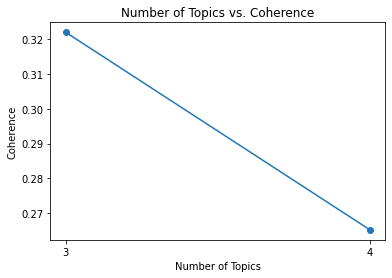

In [ ]:
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

The improvement stops to significantly improve after 15 topics. It is not always where the highest Cv is, so we can try a couple to see which has the best result. We'll try 15 and 23 here. Adding topics can help reveal further sub topics. Nonetheless, if the same words start to appear across multiple topics, the number of topics is too high.

## LDA Model Word Frequencies

Some explanation of the parameters that can be tuned:
- Passes: The number of times model iterates through the whole corpus
- Iterations: The number of iterations the model trains on each pass
- Chunk size: Number of rows that are taken to train the model each 

Other explanation of parameters: https://radimrehurek.com/gensim/models/ldamodel.html

In [ ]:
Lda1 = gensim.models.ldamodel.LdaModel
ldamodel = Lda1(doc_term_matrix, num_topics=10, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [ ]:
vis = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.069379  0.045766       1        1  43.518580
5      0.125365  0.055480       2        1  28.101833
1      0.136726 -0.065851       3        1   9.074101
4      0.088567  0.002645       4        1   5.894899
7     -0.084067  0.198840       5        1   4.924357
9      0.046440 -0.059706       6        1   2.952513
0     -0.050672 -0.017652       7        1   2.906115
2     -0.079974 -0.062176       8        1   2.475797
3     -0.124899 -0.045468       9        1   0.135600
6     -0.126866 -0.051878      10        1   0.016205, topic_info=                Term        Freq       Total Category  logprob  loglift
225        president  649.000000  649.000000  Default  30.0000  30.0000
331            world  191.000000  191.000000  Default  29.0000  29.0000
196           nation  249.000000  249.000000  Default  28.0000  28.0000
118             fact  184.000000  184.000000  Default  27.0000  27.0000
265           school  167.000000  167.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
212     pennsylvania    0.001102   32.579940  Topic10  -8.3979  -1.5669
614             word    0.001102   90.746954  Topic10  -8.3979  -2.5912
2695          kamala    0.001102   18.905568  Topic10  -8.3979  -1.0226
930       leadership    0.001102   52.608049  Topic10  -8.3979  -2.0460
4     administration    0.001102   87.675523  Topic10  -8.3979  -2.5568

[712 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.456204  ability
0         2  0.423618  ability
0         6  0.032586  ability
0         7  0.065172  ability
0         8  0.032586  ability
...     ...       ...      ...
978       7  0.399222     yeah
1258      1  0.159992     york
1258      2  0.479977     york
1258      3  0.319984     york
1258      7  0.079996     york

[1318 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 2, 5, 8, 10, 1, 3, 4, 7])

In [ ]:
# To show initial topics
ldamodel.show_topics(15, num_words=50, formatted=True)

[(0,
  '0.016*"beau" + 0.013*"dad" + 0.013*"moment" + 0.012*"family" + 0.011*"yeah" + 0.009*"power" + 0.009*"president" + 0.008*"run" + 0.008*"mm_hmm" + 0.008*"home" + 0.008*"mother" + 0.008*"soul" + 0.008*"man" + 0.007*"boy" + 0.005*"delaware" + 0.005*"teach" + 0.005*"joe" + 0.005*"dignity" + 0.005*"pay" + 0.005*"courage" + 0.005*"chance" + 0.005*"hunter" + 0.005*"train" + 0.005*"decision" + 0.005*"campaign" + 0.005*"vote" + 0.004*"word" + 0.004*"race" + 0.004*"hell" + 0.004*"daughter" + 0.004*"parent" + 0.004*"win" + 0.004*"state" + 0.004*"wouldn" + 0.004*"anybody" + 0.003*"kid" + 0.003*"car" + 0.003*"eye" + 0.003*"father" + 0.003*"abuse" + 0.003*"vision" + 0.003*"press" + 0.003*"notion" + 0.003*"brain" + 0.003*"spirit" + 0.003*"someplace" + 0.003*"help" + 0.003*"story" + 0.003*"election" + 0.003*"senator"'),
 (1,
  '0.025*"president" + 0.018*"job" + 0.017*"fact" + 0.012*"business" + 0.011*"number" + 0.010*"state" + 0.010*"country" + 0.009*"help" + 0.009*"question" + 0.009*"vote" + 0

In [ ]:
Lda5 = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda5(doc_term_matrix, num_topics=8, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [ ]:
vis = gensimvis.prepare(ldamodel2, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.115126  0.033353       1        1  44.662851
1      0.108195  0.041285       2        1  22.208675
7      0.085768 -0.126751       3        1  12.920802
4      0.078721  0.099194       4        1  11.611454
2     -0.014256 -0.106406       5        1   5.229708
0     -0.073155  0.028221       6        1   2.910177
6     -0.160099  0.016804       7        1   0.436077
3     -0.140301  0.014299       8        1   0.020255, topic_info=                 Term        Freq       Total Category  logprob  loglift
604              vote  218.000000  218.000000  Default  30.0000  30.0000
331             world  192.000000  192.000000  Default  29.0000  29.0000
225         president  650.000000  650.000000  Default  28.0000  28.0000
196            nation  242.000000  242.000000  Default  27.0000  27.0000
83                dad  101.000000  101.000000  Default  26.0000  26.0000
...               ...         ...         ...      ...      ...      ...
1876  systemic_racism    0.001377    5.819069   Topic8  -8.3979   0.1557
121              fear    0.001377   32.555170   Topic8  -8.3979  -1.5661
1862          respond    0.001377   22.697926   Topic8  -8.3979  -1.2055
1913             nand    0.001377   28.830138   Topic8  -8.3979  -1.4446
339             anger    0.001377   17.919371   Topic8  -8.3979  -0.9691

[590 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2475      2  0.921469  accumulate
852       1  0.657387      action
852       2  0.175303      action
852       3  0.065739      action
852       4  0.065739      action
...     ...       ...         ...
616       3  0.914238       wound
978       1  0.168099        yeah
978       2  0.378223        yeah
978       3  0.042025        yeah
978       6  0.378223        yeah

[1028 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 8, 5, 3, 1, 7, 4])

In [ ]:
# To show initial topics
ldamodel2.show_topics(16, num_words=50, formatted=False)

[(0,
  [('dad', 0.00022541768),
   ('school', 0.00022539054),
   ('home', 0.00022536995),
   ('family', 0.00022536951),
   ('dignity', 0.00022536465),
   ('world', 0.00022536438),
   ('scranton', 0.00022536072),
   ('pay', 0.0002253584),
   ('child', 0.00022535447),
   ('folk', 0.0002253524),
   ('kid', 0.00022535144),
   ('america', 0.00022535106),
   ('percent', 0.00022535046),
   ('country', 0.00022535033),
   ('job', 0.00022534897),
   ('middle_class', 0.00022534782),
   ('delaware', 0.00022534735),
   ('mom', 0.00022534627),
   ('raise', 0.00022534607),
   ('everybody', 0.00022534553),
   ('president', 0.0002253451),
   ('god', 0.00022534376),
   ('money', 0.00022534313),
   ('community_college', 0.00022534309),
   ('corporation', 0.00022534294),
   ('mother', 0.00022534214),
   ('word', 0.00022534201),
   ('courage', 0.00022534103),
   ('fact', 0.00022534083),
   ('hell', 0.0002253405),
   ('deserve', 0.0002253401),
   ('cost', 0.00022533999),
   ('nation', 0.00022533975),
   ('c

# Word Cloud

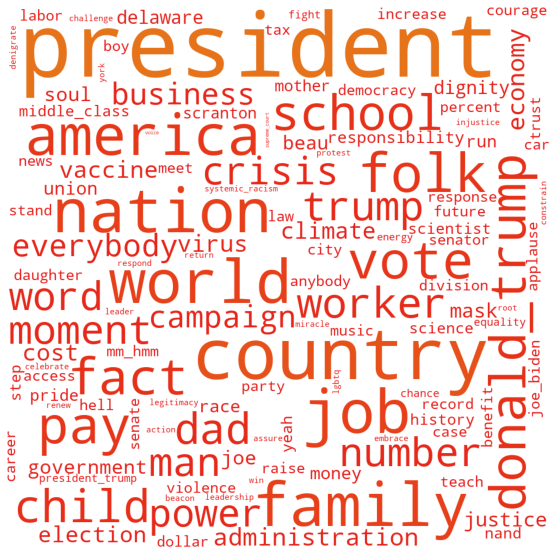

In [ ]:
def my_tf_color_func(dictionary):
  def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(%d, 80%%, 50%%)" % (360 * dictionary[word])
  return my_tf_color_func_inner

secondary_stop = ["minute", "story_short", "malar_rash", "flare","bowel_movement","body", "test","knee_pain","pain", "community","stool","disease","hospital","health","nurse","symptom","parent","prednisone","colonoscopy_endoscopy","patient","state", "colorectal_surgeon","colonoscopy","body_ache", "excrutiating_pain","kid","dull_ache","sharp_pain","medicine","phone","medication","benlysta","rheumatologist","infection","ibs", "information","husband","sinus_infection", "heart_rate","advice","friend","home","idk","drop", "humira","hey","rash","plaquenil","support","remicade","mom","discharge","control","activity","contact","story","question","crohns","celiac_disease","ibd","amp","idea","remicade_infusion","bowel_obstruction", "stool_sample","mg_prednisone", "sore_throat","terminal_ileum", "help", "rheumatoid_arthritis", "ulcerative_colitis", "cell_count", "crohns_colitis"]
topic_list = ldamodel2.show_topics(15, num_words=50, formatted=False) 
topics_df = pd.DataFrame()
for topic in topic_list:
  topic_num = topic[0]
  topic_dict = topic[1]
  df = pd.DataFrame(topic_dict, columns=['term', 'score'])
  topics_df = topics_df.append(df)
grouped_topics = topics_df.groupby("term").sum().reset_index()
grouped_topics = grouped_topics.sort_values("score", ascending=False)
grouped_topics = grouped_topics[~grouped_topics['term'].isin(secondary_stop)]
#print(list(set(grouped_topics.term)))
#grouped_topics["score"] = (grouped_topics.score - grouped_topics.score.min())/(grouped_topics.score.max() - grouped_topics.score.min())
grouped_topics = list(grouped_topics.itertuples(index=False))
wordcloud = WordCloud(background_color='white', width=1000, height=1000, color_func=my_tf_color_func(dict(grouped_topics))).generate_from_frequencies(dict(grouped_topics)) 
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud) 
plt.axis("off");

Sometimes, words that are ranked as top words for a given topic may be ranked high because they are globally frequent across text in a corpus. Relevancy score helps to prioritize terms that belong more exclusively to a given topic. This can increase interpretability even more. The relevance of term w to topic k is defined as:

$ r(w,k| \lambda) = \lambda log(\phi_{kw}) +(1-\lambda)log(\frac{\phi_{kw}}{p_{kw}}) $

where $\phi_{kw}$ is the probability of term w in topic k and $\frac{\phi_{kw}}{p_{kw}}$ is lift in term's probability within a topic to its marginal probability across the corpus (this helps discards globally frequent terms).  A lower lambda value gives more importance to the second term, which gives more importance to topic exclusivity.
